# Git Figures Precusor

##### Polished code for figures

## Setup Environment

In [13]:
import numpy as np
import scipy as sp
from scipy import stats
from sklearn.decomposition import NMF
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pickle
import FiguresModule as fm

In [14]:
import importlib
importlib.reload(fm)

<module 'FiguresModule' from '/home/jupyter-panchy/NMFviaSKLearn/gitFigures/FiguresModule.py'>

## -------A549 Model-------

#### Load A549 data and meta data

In [15]:
# Read files
A549_Egenes_lines = [ln.strip() for ln in open("A549_E_nonnegative_transpose.csv","r").readlines()]
A549_Esamples, A549_Evalues = fm.Process_scRNA_CSV(A549_Egenes_lines)
A549_Mgenes_lines = [ln.strip() for ln in open("A549_M_nonnegative_transpose.csv","r").readlines()]
A549_Msamples, A549_Mvalues = fm.Process_scRNA_CSV(A549_Mgenes_lines)

# Convert values to a numpy array and check shape
array_A549_Evalues = np.array(A549_Evalues)
print(array_A549_Evalues.shape)
array_A549_Mvalues = np.array(A549_Mvalues)
print(array_A549_Mvalues.shape)

(3568, 176)
(3568, 117)


In [16]:
# Prepare Meta-data and get time lables for startified cross-val
A549_meta_lines = [ln.strip() for ln in open("A549_meta.csv").readlines()]

A549_meta_samples = []
A549_Time_labels = []
for ln in A549_meta_lines[1:]:
    split_ln = ln.split(",")
    values = [v.strip("''").strip('""') for v in split_ln]
    A549_meta_samples.append(values[0])
    A549_Time_labels.append(values[8])
    
print(A549_Time_labels[:10])

['3d', '3d', '3d', '3d', '3d', '7d', '3d', '1d', '7d', '3d']


In [17]:
# Turn label in to times (in hours)
A549_Reannot_time = fm.Reannotate_Time(A549_Time_labels)
A549_Reannot_colors = fm.Time_to_Color(A549_Time_labels)

In [18]:
# Get lists for sample for all different time points
time_0d_idxs, time_8h_idxs, time_1d_idxs, time_3d_idxs, time_7d_idxs, time_8h_rm_idxs, time_1d_rm_idxs, time_3d_rm_idxs = fm.Get_Time_Idxs(A549_Time_labels) 

### A549 model of all data

In [19]:
# Make model on all data
model = NMF(n_components=2, init='random', random_state=1001)
A549_Reannot_time = fm.Reannotate_Time(A549_Time_labels)
W_E = model.fit_transform(array_A549_Evalues)
W_M = model.fit_transform(array_A549_Mvalues)

In [20]:
# Get the non-revertant portion
A549_no_rev_index = []
for i in range(len(A549_Reannot_time)):
        if A549_Reannot_time[i] < 176:
            A549_no_rev_index.append(i)
            
A549_Reannot_time_noRev = [A549_Reannot_time[v] for v in A549_no_rev_index]
W_E_noRev = W_E[A549_no_rev_index,:]
W_M_noRev = W_M[A549_no_rev_index,:]

In [21]:
# Find Best Features
best_E_Feature_noRev, best_E_corr, best_E_index = fm.GetNegCoefFeature(W_E_noRev,A549_Reannot_time_noRev)
best_M_Feature_noRev, best_M_corr, best_M_index = fm.GetPosCoefFeature(W_M_noRev,A549_Reannot_time_noRev)
print("Best E-score PCC:\t" + "{:.3}".format(best_E_corr) + " ( index =" + str(best_E_index) + ")")
print("Best M-score PCC:\t" + "{:.3}".format(best_M_corr) + " ( index =" + str(best_M_index) + ")")

Best E-score PCC:	-0.567 ( index =1)
Best M-score PCC:	0.713 ( index =1)


In [22]:
best_E_Feature = W_E[:,best_E_index]
best_M_Feature = W_M[:,best_M_index]

##### All Data Points

Text(0, 0.5, 'M Score')

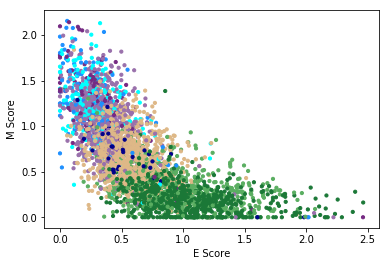

In [23]:
plt.scatter(best_E_Feature,best_M_Feature,s=10,c=A549_Reannot_colors)
plt.xlabel("E Score")
plt.ylabel("M Score")

##### EMT Progression Only (no revertant points)

In [24]:
A549_Reannot_norRev_colors = [A549_Reannot_colors[i] for i in A549_no_rev_index]

Text(0, 0.5, 'M Score')

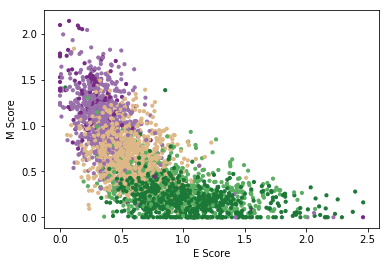

In [25]:
plt.scatter(best_E_Feature[A549_no_rev_index],best_M_Feature[A549_no_rev_index],s=10,c=A549_Reannot_norRev_colors)
plt.xlabel("E Score")
plt.ylabel("M Score")

In [26]:
noRev_reg = LinearRegression().fit(np.array([W_E[A549_no_rev_index,1], W_M[A549_no_rev_index,1]]).transpose(), A549_Reannot_time_noRev)
noRev_reg_R2 = noRev_reg.score(np.array([W_E[A549_no_rev_index,1], W_M[A549_no_rev_index,1]]).transpose(), A549_Reannot_time_noRev)
print("DU145 Model Adjusted R2:\t" + "{:.3}".format(noRev_reg_R2))

DU145 Model Adjusted R2:	0.52


### Seperation of Time Point Samples

##### E-scores

In [27]:
pv08, f08 = fm.ScoreFProb(best_E_Feature,time_0d_idxs,time_8h_idxs)
pv81, f81 = fm.ScoreFProb(best_E_Feature,time_8h_idxs,time_1d_idxs)
pv13, f13 = fm.ScoreFProb(best_E_Feature,time_1d_idxs,time_3d_idxs)
pv37, f37 = fm.ScoreFProb(best_E_Feature,time_3d_idxs,time_7d_idxs)
pv73rm, f73rm = fm.ScoreFProb(best_E_Feature,time_3d_rm_idxs,time_7d_idxs)

print("0 days vs. 8 hours:\t" + "{:.3}".format(f08) + " (" + "{:.3}".format(pv08) + ")" )
print("8 hours vs. 1 day:\t" + "{:.3}".format(f81) + " (" + "{:.3}".format(pv81) + ")" )
print("1 day vs. 3days:\t" + "{:.3}".format(f13) + " (" + "{:.3}".format(pv13) + ")" )
print("3 days vs. 7days:\t" + "{:.3}".format(f37) + " (" + "{:.3}".format(pv37) + ")" )
print("7 days vs. 7+3days_rm:\t" + "{:.3}".format(f73rm) + " (" + "{:.3}".format(pv73rm) + ")" )

0 days vs. 8 hours:	0.607 (2.61e-12)
8 hours vs. 1 day:	0.839 (5.17e-127)
1 day vs. 3days:	0.791 (2.86e-87)
3 days vs. 7days:	0.629 (1.47e-06)
7 days vs. 7+3days_rm:	0.835 (3.81e-11)


#### M-scores

In [28]:
pv08, f08 = fm.ScoreFProb(best_M_Feature,time_8h_idxs,time_0d_idxs)
pv81, f81 = fm.ScoreFProb(best_M_Feature,time_1d_idxs,time_8h_idxs)
pv13, f13 = fm.ScoreFProb(best_M_Feature,time_3d_idxs,time_1d_idxs)
pv37, f37 = fm.ScoreFProb(best_M_Feature,time_7d_idxs,time_3d_idxs)
pv73rm, f73rm = fm.ScoreFProb(best_M_Feature,time_7d_idxs,time_3d_rm_idxs)

print("0 days vs. 8 hours:\t" + "{:.3}".format(f08) + " (" + "{:.3}".format(pv08) + ")" )
print("8 hours vs. 1 day:\t" + "{:.3}".format(f81) + " (" + "{:.3}".format(pv81) + ")" )
print("1 day vs. 3days:\t" + "{:.3}".format(f13) + " (" + "{:.3}".format(pv13) + ")" )
print("3 days vs. 7days:\t" + "{:.3}".format(f37) + " (" + "{:.3}".format(pv37) + ")" )
print("7 days vs. 7+3days_rm:\t" + "{:.3}".format(f73rm) + " (" + "{:.3}".format(pv73rm) + ")" )

0 days vs. 8 hours:	0.698 (4.73e-38)
8 hours vs. 1 day:	0.86 (1.56e-143)
1 day vs. 3days:	0.818 (3.05e-104)
3 days vs. 7days:	0.637 (3.5e-07)
7 days vs. 7+3days_rm:	0.862 (9.45e-13)


### Infer Missing Time Points

#### -Drop 1st day-

In [29]:
Drop_1day_indexes = [i for i in range(len(A549_Time_labels)) if i not in time_1d_idxs]

In [30]:
array_A549_Evalues_drop1day = [array_A549_Evalues[i] for i in Drop_1day_indexes]
array_A549_Mvalues_drop1day = [array_A549_Mvalues[i] for i in Drop_1day_indexes]
array_A549_Evalues_1day = [array_A549_Evalues[i] for i in time_1d_idxs]
array_A549_Mvalues_1day = [array_A549_Mvalues[i] for i in time_1d_idxs]
Time_labels_drop1day = [A549_Time_labels[i] for i in Drop_1day_indexes]

In [31]:
# Time indexes for Drop 1st day
time_0d_drop1_idxs, time_8h_drop1_idxs, time_1d_drop1_idxs, time_3d_drop1_idxs, time_7d_drop1_idxs, time_8h_rm_drop1_idxs, time_1d_rm_drop1_idxs, time_3d_rm_drop1_idxs = fm.Get_Time_Idxs(Time_labels_drop1day) 

In [32]:
model = NMF(n_components=2, init='random', random_state=1001)
Reannot_time_drop1day = fm.Reannotate_Time(Time_labels_drop1day)
W_E_drop1 = model.fit_transform(array_A549_Evalues_drop1day)
W_E_1day = model.transform(array_A549_Evalues_1day)
W_M_drop1 = model.fit_transform(array_A549_Mvalues_drop1day)
W_M_1day = model.transform(array_A549_Mvalues_1day)

In [33]:
# Get the non-revertant portion
no_rev_index = []
for i in range(len(Reannot_time_drop1day)):
        if Reannot_time_drop1day[i] < 176:
            no_rev_index.append(i)
            
Reannot_time_drop1day_noRev = [Reannot_time_drop1day[v] for v in no_rev_index]
W_E_drop1_noRev = W_E_drop1[no_rev_index,:]
W_M_drop1_noRev = W_M_drop1[no_rev_index,:]

In [34]:
best_E_Feature_drop1_noRev, best_E_corr_drop1_noRev, best_E_index_drop1_noRev = fm.GetNegCoefFeature(W_E_drop1_noRev,Reannot_time_drop1day_noRev)
best_M_Feature_drop1_noRev, best_M_corr_drop1_noRev, best_M_index_drop1_noRev = fm.GetPosCoefFeature(W_M_drop1_noRev,Reannot_time_drop1day_noRev)
print("Best E-score PCC:\t" + "{:.3}".format(best_E_corr_drop1_noRev) + " ( index =" + str(best_E_index_drop1_noRev) + ")")
print("Best M-score PCC:\t" + "{:.3}".format(best_M_corr_drop1_noRev) + " ( index =" + str(best_M_index_drop1_noRev) + ")")

Best E-score PCC:	-0.636 ( index =1)
Best M-score PCC:	0.774 ( index =1)


In [35]:
best_E_Feature_drop1 = W_E_drop1[:,best_E_index_drop1_noRev]
best_M_Feature_drop1 = W_M_drop1[:,best_M_index_drop1_noRev]

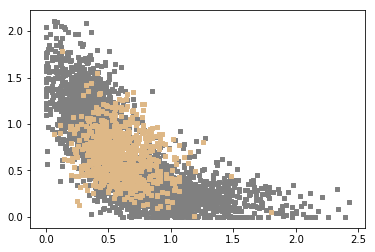

In [36]:
plt.scatter(best_E_Feature_drop1, best_M_Feature_drop1, s=10, c='grey', marker="s", label='first')
plt.scatter(W_E_1day[:,1], W_M_1day[:,1], s=10, c="#DEB887", marker="s", label='first')

#### Correlation

In [37]:
Ecorr, Ecorr_pv = sp.stats.pearsonr(W_E_1day[:,1],best_E_Feature[time_1d_idxs])
Mcorr, Mcorr_pv = sp.stats.pearsonr(W_M_1day[:,1],best_M_Feature[time_1d_idxs])

print("Correlation between origilna 1-day samples and inferred 1-day samples:")
print("E-score correlation:" + "{:.3}".format(Ecorr) + " (" + "{:.3}".format(Ecorr_pv) + ")" )
print("M-score correlation:" + "{:.3}".format(Mcorr) + " (" + "{:.3}".format(Mcorr_pv) + ")" )

Correlation between origilna 1-day samples and inferred 1-day samples:
E-score correlation:0.998 (0.0)
M-score correlation:0.999 (0.0)


#### Seperation

##### E-scores

In [38]:
pv81_drop, f81_drop = fm.ScoreFProb_Drop(best_E_Feature_drop1,time_8h_drop1_idxs,W_E_1day[:,1],'greater')
pv13_drop, f13_drop = fm.ScoreFProb_Drop(best_E_Feature_drop1,time_3d_drop1_idxs,W_E_1day[:,1],'less')

print("8 hours vs 1 day (dropped):\t" + "{:.3}".format(f81_drop) + " (" + "{:.3}".format(pv81_drop) + ")" )
print("1 day (dropped) vs 3 day:\t" + "{:.3}".format(f13_drop) + " (" + "{:.3}".format(pv13_drop) + ")" )

8 hours vs 1 day (dropped):	0.829 (2.43e-120)
1 day (dropped) vs 3 day:	0.808 (1.15e-97)


##### M-scores

In [39]:
pv81_drop, f81_drop = fm.ScoreFProb_Drop(best_M_Feature_drop1,time_8h_drop1_idxs,W_M_1day[:,1],'less')
pv13_drop, f13_drop = fm.ScoreFProb_Drop(best_M_Feature_drop1,time_3d_drop1_idxs,W_M_1day[:,1],'greater')

print("8 hours vs 1 day (dropped):\t" + "{:.3}".format(f81_drop) + " (" + "{:.3}".format(pv81_drop) + ")" )
print("1 day (dropped) vs 3 day:\t" + "{:.3}".format(f13_drop) + " (" + "{:.3}".format(pv13_drop) + ")" )

8 hours vs 1 day (dropped):	0.865 (1.83e-147)
1 day (dropped) vs 3 day:	0.819 (9.27e-105)


#### -Drop 0-day-

In [40]:
Drop_0day_indexes = [i for i in range(len(A549_Time_labels)) if i not in time_0d_idxs]

In [41]:
array_A549_Evalues_drop0day = [array_A549_Evalues[i] for i in Drop_0day_indexes]
array_A549_Mvalues_drop0day = [array_A549_Mvalues[i] for i in Drop_0day_indexes]
array_A549_Evalues_0day = [array_A549_Evalues[i] for i in time_0d_idxs]
array_A549_Mvalues_0day = [array_A549_Mvalues[i] for i in time_0d_idxs]
Time_labels_drop0day = [A549_Time_labels[i] for i in Drop_0day_indexes]

##### Time indexes for Drop 0 day

In [42]:
time_0d_drop0_idxs, time_8h_drop0_idxs, time_1d_drop0_idxs, time_3d_drop0_idxs, time_7d_drop0_idxs, time_8h_rm_drop0_idxs, time_1d_rm_drop0_idxs, time_3d_rm_drop0_idxs = fm.Get_Time_Idxs(Time_labels_drop0day) 

In [43]:
model = NMF(n_components=2, init='random', random_state=1001)
Reannot_time_drop0day = fm.Reannotate_Time(Time_labels_drop0day)
W_E_drop0 = model.fit_transform(array_A549_Evalues_drop0day)
W_E_0day = model.transform(array_A549_Evalues_0day)
W_M_drop0 = model.fit_transform(array_A549_Mvalues_drop0day)
W_M_0day = model.transform(array_A549_Mvalues_0day)

In [44]:
# Get the non-revertant portion
no_rev_index = []
for i in range(len(Reannot_time_drop0day)):
        if Reannot_time_drop0day[i] < 176:
            no_rev_index.append(i)
            
Reannot_time_drop0day_noRev = [Reannot_time_drop0day[v] for v in no_rev_index]
W_E_drop0_noRev = W_E_drop0[no_rev_index,:]
W_M_drop0_noRev = W_M_drop0[no_rev_index,:]

In [45]:
best_E_Feature_drop0_noRev, best_E_corr_drop0_noRev, best_E_index_drop0_noRev = fm.GetNegCoefFeature(W_E_drop0_noRev,Reannot_time_drop0day_noRev)
best_M_Feature_drop0_noRev, best_M_corr_drop0_noRev, best_M_index_drop0_noRev = fm.GetPosCoefFeature(W_M_drop0_noRev,Reannot_time_drop0day_noRev)
print("Best E-score PCC:\t" + "{:.3}".format(best_E_corr_drop0_noRev) + " ( index =" + str(best_E_index_drop0_noRev) + ")")
print("Best M-score PCC:\t" + "{:.3}".format(best_M_corr_drop0_noRev) + " ( index =" + str(best_M_index_drop0_noRev) + ")")

Best E-score PCC:	-0.565 ( index =1)
Best M-score PCC:	0.68 ( index =1)


In [46]:
best_E_Feature_drop0 = W_E_drop0[:,best_E_index_drop0_noRev]
best_M_Feature_drop0 = W_M_drop0[:,best_M_index_drop0_noRev]

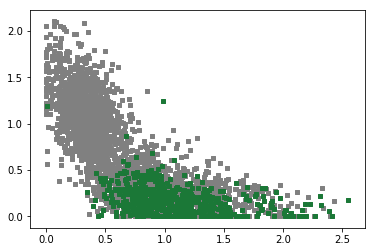

In [47]:
plt.scatter(best_E_Feature_drop1, best_M_Feature_drop1, s=10, c='grey', marker="s", label='first')
plt.scatter(W_E_0day[:,1], W_M_0day[:,1], s=10, c="#1B7837", marker="s", label='first')

##### Correlation

In [48]:
Ecorr, Ecorr_pv = sp.stats.pearsonr(W_E_0day[:,1],best_E_Feature[time_0d_idxs])
Mcorr, Mcorr_pv = sp.stats.pearsonr(W_M_0day[:,1],best_M_Feature[time_0d_idxs])

print("Correlation between origilna 0-day samples and inferred 0-day samples:")
print("E-score correlation:" + "{:.3}".format(Ecorr) + " (" + "{:.3}".format(Ecorr_pv) + ")" )
print("M-score correlation:" + "{:.3}".format(Mcorr) + " (" + "{:.3}".format(Mcorr_pv) + ")" )

Correlation between origilna 0-day samples and inferred 0-day samples:
E-score correlation:0.989 (0.0)
M-score correlation:0.958 (2.12e-314)


#### Seperation

##### E-scores

In [49]:
pv08_drop, f08_drop = fm.ScoreFProb_Drop(best_E_Feature_drop0,time_8h_drop0_idxs,W_E_0day[:,1],'less')

print("0 days (dropped) vs 8 hours:\t" + "{:.3}".format(f08_drop) + " (" + "{:.3}".format(pv08_drop) + ")" )

0 days (dropped) vs 8 hours:	0.524 (0.0617)


##### M-scores

In [50]:
pv08_drop, f08_drop = fm.ScoreFProb_Drop(best_M_Feature_drop0,time_8h_drop0_idxs,W_M_0day[:,1],'greater')

print("0 days (dropped) vs 8 hours:\t" + "{:.3}".format(f08_drop) + " (" + "{:.3}".format(pv08_drop) + ")" )

0 days (dropped) vs 8 hours:	0.561 (3.42e-05)


#### -Drop Everything after 3 days-

In [51]:
Early_indexes = []
Late_indexes = []

Early_indexes.extend(time_0d_idxs)
Early_indexes.extend(time_8h_idxs)
Early_indexes.extend(time_1d_idxs)
Early_indexes.extend(time_3d_idxs)

Late_indexes.extend(time_7d_idxs)
Late_indexes.extend(time_8h_rm_idxs)
Late_indexes.extend(time_1d_rm_idxs)
Late_indexes.extend(time_3d_rm_idxs)

In [52]:
array_A549_Evalues_early = [array_A549_Evalues[i] for i in Early_indexes]
array_A549_Mvalues_early = [array_A549_Mvalues[i] for i in Early_indexes]
array_A549_Evalues_late = [array_A549_Evalues[i] for i in Late_indexes]
array_A549_Mvalues_late = [array_A549_Mvalues[i] for i in Late_indexes]
array_A549_Evalues_7day = [array_A549_Evalues[i] for i in time_7d_idxs]
array_A549_Mvalues_7day = [array_A549_Mvalues[i] for i in time_7d_idxs]

Time_labels_early = [A549_Time_labels[i] for i in Early_indexes]
Time_labels_late = [A549_Time_labels[i] for i in Late_indexes]
Time_labels_7day = [A549_Time_labels[i] for i in time_7d_idxs]

##### Time indexes for our early and late set

In [53]:
time_0d_early_idxs, time_8h_early_idxs, time_1d_early_idxs, time_3d_early_idxs, time_7d_early_idxs, time_8h_rm_early_idxs, time_1d_rm_early_idxs, time_3d_rm_early_idxs = fm.Get_Time_Idxs(Time_labels_early) 
time_0d_late_idxs, time_8h_late_idxs, time_1d_late_idxs, time_3d_late_idxs, time_7d_late_idxs, time_8h_rm_late_idxs, time_1d_rm_late_idxs, time_3d_rm_late_idxs = fm.Get_Time_Idxs(Time_labels_late) 

In [54]:
model = NMF(n_components=2, init='random', random_state=1001)
Reannot_time_early = fm.Reannotate_Time(Time_labels_early)
Reannot_time_late = fm.Reannotate_Time(Time_labels_late)
Reannot_time_7day = fm.Reannotate_Time(Time_labels_7day)
W_E_early = model.fit_transform(array_A549_Evalues_early)
W_E_late = model.transform(array_A549_Evalues_late)
W_E_7day = model.transform(array_A549_Evalues_7day)
W_M_early = model.fit_transform(array_A549_Mvalues_early)
W_M_late = model.transform(array_A549_Mvalues_late)
W_M_7day = model.transform(array_A549_Mvalues_7day)

In [55]:
# No need to calc reverse here
best_E_Feature_early, best_E_corr_early, best_E_index_early = fm.GetNegCoefFeature(W_E_early,Reannot_time_early)
best_M_Feature_early, best_M_corr_early, best_M_index_early = fm.GetPosCoefFeature(W_M_early,Reannot_time_early)
print("Best E-score PCC:\t" + "{:.3}".format(best_E_corr_early) + " ( index =" + str(best_E_index_early) + ")")
print("Best M-score PCC:\t" + "{:.3}".format(best_M_corr_early) + " ( index =" + str(best_M_index_early) + ")")

Best E-score PCC:	-0.604 ( index =1)
Best M-score PCC:	0.766 ( index =1)


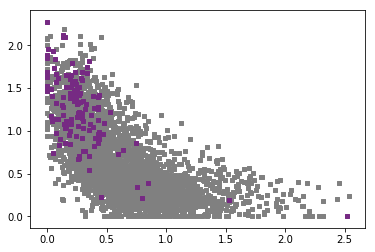

In [56]:
plt.scatter(best_E_Feature_early, best_M_Feature_early, s=10, c='grey', marker="s", label='first')
plt.scatter(W_E_7day[:,1], W_M_7day[:,1], s=10, c="#762A83", marker="s", label='first')

#### Correlation

In [57]:
Ecorr, Ecorr_pv = sp.stats.pearsonr(W_E_7day[:,1],best_E_Feature[time_7d_idxs])
Mcorr, Mcorr_pv = sp.stats.pearsonr(W_M_7day[:,1],best_M_Feature[time_7d_idxs])

print("Correlation between origilna 7-day samples and inferred 7-day samples:")
print("E-score correlation:" + "{:.3}".format(Ecorr) + " (" + "{:.3}".format(Ecorr_pv) + ")" )
print("M-score correlation:" + "{:.3}".format(Mcorr) + " (" + "{:.3}".format(Mcorr_pv) + ")" )

Correlation between origilna 7-day samples and inferred 7-day samples:
E-score correlation:0.991 (1.71e-113)
M-score correlation:0.975 (1.48e-84)


#### Seperation

##### E-scores

In [58]:
pv37_drop, f37_drop = fm.ScoreFProb_Drop(best_E_Feature_early,time_3d_early_idxs,[W_E_late[j,1] for j in time_7d_late_idxs],'greater')

print("3 days vs 7 days (dropped):\t" + "{:.3}".format(f08_drop) + " (" + "{:.3}".format(pv37_drop) + ")" )

3 days vs 7 days (dropped):	0.561 (0.0132)


##### M-scores

In [59]:
pv37_drop, f37_drop = fm.ScoreFProb_Drop(best_M_Feature_early,time_3d_early_idxs,[W_M_late[j,1] for j in time_7d_late_idxs],'less')

print("3 days vs 7 days (dropped):\t" + "{:.3}".format(f08_drop) + " (" + "{:.3}".format(pv37_drop) + ")" )

3 days vs 7 days (dropped):	0.561 (0.00983)


#### -Drop all Revertant points and infer 3day_removed-

In [60]:
Normal_indexes = []
Rev_indexes = []

Normal_indexes.extend(time_0d_idxs)
Normal_indexes.extend(time_8h_idxs)
Normal_indexes.extend(time_1d_idxs)
Normal_indexes.extend(time_3d_idxs)
Normal_indexes.extend(time_7d_idxs)

Rev_indexes.extend(time_3d_rm_idxs)

In [61]:
array_A549_Normal_E = [array_A549_Evalues[i] for i in Normal_indexes]
array_A549_Normal_M = [array_A549_Mvalues[i] for i in Normal_indexes]
array_A549_Rev_E = [array_A549_Evalues[i] for i in Rev_indexes]
array_A549_Rev_M = [array_A549_Mvalues[i] for i in Rev_indexes]

Time_labels_Normal = [A549_Time_labels[i] for i in Normal_indexes]
Time_labels_Rev = [A549_Time_labels[i] for i in Rev_indexes]

In [62]:
time_0d_norm_idxs, time_8h_norm_idxs, time_1d_norm_idxs, time_3d_norm_idxs, time_7d_norm_idxs, time_8h_rm_norm_idxs, time_1d_rm_norm_idxs, time_3d_rm_norm_idxs = fm.Get_Time_Idxs(Time_labels_Normal) 
time_0d_rev_idxs, time_8h_rev_idxs, time_1d_rev_idxs, time_3d_rev_idxs, time_7d_rev_idxs, time_8h_rm_rev_idxs, time_1d_rm_rev_idxs, time_3d_rm_rev_idxs = fm.Get_Time_Idxs(Time_labels_Rev) 

In [63]:
model = NMF(n_components=2, init='random', random_state=1001)
Reannot_time_Norm = fm.Reannotate_Time(Time_labels_Normal)
Reannot_time_Rev = fm.Reannotate_Time(Time_labels_Rev)

W_E_Norm = model.fit_transform(array_A549_Normal_E)
W_E_Rev = model.transform(array_A549_Rev_E)

W_M_Norm = model.fit_transform(array_A549_Normal_M)
W_M_Rev = model.transform(array_A549_Rev_M)


In [64]:
best_E_Feature_Norm, best_E_corr_Norm, best_E_index_Norm = fm.GetNegCoefFeature(W_E_Norm,Reannot_time_Norm)
best_M_Feature_Norm, best_M_corr_Norm, best_M_index_Norm = fm.GetPosCoefFeature(W_M_Norm,Reannot_time_Norm)
print("Best E-score PCC:\t" + "{:.3}".format(best_E_corr_Norm) + " ( index =" + str(best_E_index_Norm) + ")")
print("Best M-score PCC:\t" + "{:.3}".format(best_M_corr_Norm) + " ( index =" + str(best_M_index_Norm) + ")")

Best E-score PCC:	-0.541 ( index =1)
Best M-score PCC:	0.697 ( index =1)


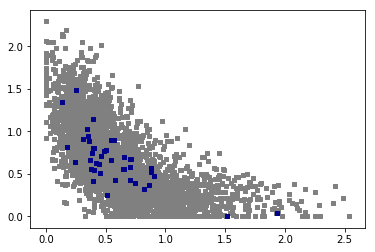

In [65]:
plt.scatter(best_E_Feature_Norm, best_M_Feature_Norm, s=10, c='grey', marker="s", label='first')
plt.scatter(W_E_Rev[:,1], W_M_Rev[:,1], s=10, c="#00008B", marker="s", label='first')

#### Correlation

In [66]:
Ecorr, Ecorr_pv = sp.stats.pearsonr(W_E_Rev[:,1],best_E_Feature[time_3d_rm_idxs])
Mcorr, Mcorr_pv = sp.stats.pearsonr(W_M_Rev[:,1],best_M_Feature[time_3d_rm_idxs])

print("Correlation between origilna 3-day removed samples and inferred 3-day removed samples:")
print("E-score correlation:" + "{:.3}".format(Ecorr) + " (" + "{:.3}".format(Ecorr_pv) + ")" )
print("M-score correlation:" + "{:.3}".format(Mcorr) + " (" + "{:.3}".format(Mcorr_pv) + ")" )

Correlation between origilna 3-day removed samples and inferred 3-day removed samples:
E-score correlation:0.998 (1.77e-50)
M-score correlation:0.982 (1.26e-30)


#### Seperation

##### E-scores

In [67]:
pv73rm_drop, f73rm_drop = fm.ScoreFProb_Drop(best_E_Feature_Norm,time_7d_norm_idxs,W_E_Rev[:,1],'less')
print("7 days vs 3-days removed (dropped):\t" + "{:.3}".format(f73rm_drop) + " (" + "{:.3}".format(pv73rm_drop) + ")" )

7 days vs 3-days removed (dropped):	0.845 (1.06e-11)


##### M-scores

In [68]:
pv73rm_drop, f73rm_drop = fm.ScoreFProb_Drop(best_M_Feature_Norm,time_7d_norm_idxs,W_M_Rev[:,1],'greater')
print("7 days vs 3-days removed (dropped):\t" + "{:.3}".format(f73rm_drop) + " (" + "{:.3}".format(pv73rm_drop) + ")" )

7 days vs 3-days removed (dropped):	0.88 (8.04e-14)


## -------DU145 Models-------

##### DU145 Data

In [69]:
# Read files
DU145_Egenes_lines = [ln.strip() for ln in open("DU145_E_nonnegative_transpose.csv","r").readlines()]
DU145_Esamples, DU145_Evalues = fm.Process_scRNA_CSV(DU145_Egenes_lines)
DU145_Mgenes_lines = [ln.strip() for ln in open("DU145_M_nonnegative_transpose.csv","r").readlines()]
DU145_Msamples, DU145_Mvalues = fm.Process_scRNA_CSV(DU145_Mgenes_lines)

# Convert values to a numpy array and check shape
array_DU145_Evalues = np.array(DU145_Evalues)
print(array_DU145_Evalues.shape)
array_DU145_Mvalues = np.array(DU145_Mvalues)
print(array_DU145_Mvalues.shape)

(2853, 189)
(2853, 118)


In [70]:
# Prepare Meta-data and get time lables for startified cross-val
DU145_meta_lines = [ln.strip() for ln in open("DU145_meta.csv").readlines()]

DU145_Time_labels = []
DU145_meta_samples = []
for ln in DU145_meta_lines[1:]:
    split_ln = ln.split(",")
    values = [v.strip("''").strip('""') for v in split_ln]
    DU145_meta_samples.append(values[0])
    DU145_Time_labels.append(values[8])
    
print(DU145_Time_labels[:10])

['3d_rm', '7d', '7d', '3d', '3d', '8h_rm', '7d', '1d', '8h_rm', '3d']


In [71]:
# Turn label in to times (in hours)
DU145_Reannot_time = fm.Reannotate_Time(DU145_Time_labels)
DU145_Reannot_colors = fm.Time_to_Color(DU145_Time_labels)

#### Check consistency of DU145 Models

In [72]:
W_E_PCC, W_M_PCC = fm.CheckSeedConsistency(array_DU145_Evalues,array_DU145_Mvalues)
print("Mean E-dimension Correlation:" + "\t" + str(np.mean(W_E_PCC)))
print("Mean W-dimension Correlation:" + "\t" + str(np.mean(W_M_PCC)))

Mean E-dimension Correlation:	0.9979480024690001
Mean W-dimension Correlation:	0.9943149038341169


#### DU145 Base Model

In [73]:
# Base DU145 Model
model_E = NMF(n_components=2, init='random', random_state=1001)
W_E_train_DU145 = model_E.fit_transform(array_DU145_Evalues)

model_M = NMF(n_components=2, init='random',random_state=1001)
W_M_train_DU145 = model_E.fit_transform(array_DU145_Mvalues)

DU145_Reannot_time = fm.Reannotate_Time(DU145_Time_labels)

In [74]:
# Get the non-revertant portion
DU145_no_rev_index = []
for i in range(len(DU145_Reannot_time)):
        if DU145_Reannot_time[i] < 176:
            DU145_no_rev_index.append(i)
            
DU145_Reannot_time_noRev = [DU145_Reannot_time[v] for v in DU145_no_rev_index]
W_E_train_DU145_noRev = W_E_train_DU145[DU145_no_rev_index,:]
W_M_train_DU145_noRev = W_M_train_DU145[DU145_no_rev_index,:]

In [75]:
# Find Best Features
DU145_best_E_Feature_noRev, DU145_best_E_corr, DU145_best_E_index = fm.GetNegCoefFeature(W_E_train_DU145_noRev,DU145_Reannot_time_noRev)
DU145_best_M_Feature_noRev, DU145_best_M_corr, DU145_best_M_index = fm.GetPosCoefFeature(W_M_train_DU145_noRev,DU145_Reannot_time_noRev)
print("Best E-score PCC:\t" + "{:.3}".format(DU145_best_E_corr) + " ( index =" + str(DU145_best_E_index) + ")")
print("Best M-score PCC:\t" + "{:.3}".format(DU145_best_M_corr) + " ( index =" + str(DU145_best_M_index) + ")")

Best E-score PCC:	-0.354 ( index =1)
Best M-score PCC:	0.534 ( index =1)


In [76]:
DU145_Reannot_noRev_colors = [DU145_Reannot_colors[i] for i in DU145_no_rev_index]

Text(0, 0.5, 'M Score')

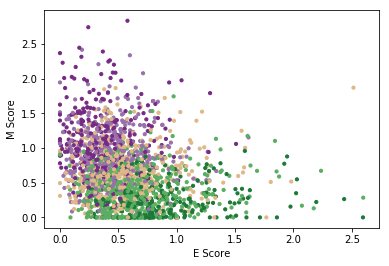

In [77]:
plt.scatter(W_E_train_DU145[DU145_no_rev_index,DU145_best_E_index],W_M_train_DU145[DU145_no_rev_index,DU145_best_M_index],s=10,c=DU145_Reannot_noRev_colors)
plt.xlabel("E Score")
plt.ylabel("M Score")

In [78]:
noRev_reg = LinearRegression().fit(np.array([W_E_train_DU145[DU145_no_rev_index,1], W_M_train_DU145[DU145_no_rev_index,1]]).transpose(), DU145_Reannot_time_noRev)
noRev_reg_R2 = noRev_reg.score(np.array([W_E_train_DU145[DU145_no_rev_index,1], W_M_train_DU145[DU145_no_rev_index,1]]).transpose(), DU145_Reannot_time_noRev)
print("DU145 Model Adjusted R2:\t" + "{:.3}".format(noRev_reg_R2))

DU145 Model Adjusted R2:	0.34


### -------A549 by DU145-------

#### A549 by DU145

In [79]:
A549_Egenes = [v.strip('"') for v in A549_Egenes_lines[0].split(",")][1:]
A549_Mgenes = [v.strip('"') for v in A549_Mgenes_lines[0].split(",")][1:]

In [80]:
DU145_Egenes = [v.strip('"') for v in DU145_Egenes_lines[0].split(",")][1:]
DU145_Mgenes = [v.strip('"') for v in DU145_Mgenes_lines[0].split(",")][1:]

In [81]:
A549_filter_values_E_array, DU145_filter_values_E_array, A549_by_DU145_Egenes = fm.FilterDataByGenes_scRNA(A549_Evalues,A549_Egenes,DU145_Evalues,DU145_Egenes)

In [82]:
print("Input Array Dimensions: E-genes")
print(np.shape(A549_filter_values_E_array))
print(np.shape(DU145_filter_values_E_array))

Input Array Dimensions: E-genes
(3568, 168)
(2853, 168)


In [83]:
A549_filter_values_M_array, DU145_filter_values_M_array, A549_by_DU145_Mgenes = fm.FilterDataByGenes_scRNA(A549_Mvalues,A549_Mgenes,DU145_Mvalues,DU145_Mgenes)

In [84]:
print("Input Array Dimensions: M-genes")
print(np.shape(A549_filter_values_M_array))
print(np.shape(DU145_filter_values_M_array))

Input Array Dimensions: M-genes
(3568, 102)
(2853, 102)


#### Fit A549 model by DU145 data

In [85]:
# Make refit model
model_E_refit = NMF(n_components=2, init='random', random_state=1001)

# E data: Train model
DU145_W_E_refit = model_E_refit.fit_transform(DU145_filter_values_E_array)
A549_by_DU145_fit_E = model_E_refit.transform(A549_filter_values_E_array)

# Make refit model
model_M_refit = NMF(n_components=2, init='random', random_state=1001)

# M data: Train model
DU145_W_M_refit = model_M_refit.fit_transform(DU145_filter_values_M_array)
A549_by_DU145_fit_M = model_M_refit.transform(A549_filter_values_M_array)

##### Compare refit to original DU145 model

In [86]:
# Find the Leading Dimension by comparison to the original model
original_vs_refit0_E = np.corrcoef(DU145_W_E_refit[:,0],W_E_train_DU145[:,DU145_best_E_index])[0,1]
original_vs_refit1_E = np.corrcoef(DU145_W_E_refit[:,1],W_E_train_DU145[:,DU145_best_E_index])[0,1]
original_vs_refit0_M = np.corrcoef(DU145_W_M_refit[:,0],W_M_train_DU145[:,DU145_best_M_index])[0,1]
original_vs_refit1_M = np.corrcoef(DU145_W_M_refit[:,1],W_M_train_DU145[:,DU145_best_M_index])[0,1]

print("E-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_E))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_E))
print("")
print("M-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_M))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_M))

E-dimension
Original vs. 1st Refit Component:	-0.718
Original vs. 2nd Refit Component:	0.977

M-dimension
Original vs. 1st Refit Component:	-0.771
Original vs. 2nd Refit Component:	0.996


Text(0, 0.5, 'M Score')

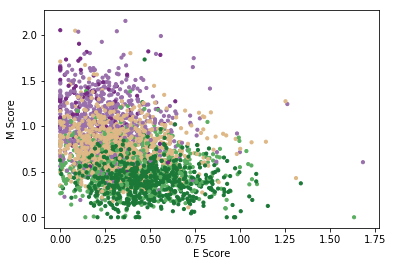

In [87]:
plt.scatter(A549_by_DU145_fit_E[A549_no_rev_index,1],A549_by_DU145_fit_M[A549_no_rev_index,1],s=10,c=A549_Reannot_norRev_colors)
plt.xlabel("E Score")
plt.ylabel("M Score")

In [88]:
A549_Reannot_time_noRev = [A549_Reannot_time[v] for v in A549_no_rev_index]
noRev_reg = LinearRegression().fit(np.array([A549_by_DU145_fit_E[A549_no_rev_index,1], A549_by_DU145_fit_M[A549_no_rev_index,1]]).transpose(), A549_Reannot_time_noRev)
noRev_reg_R2 = noRev_reg.score(np.array([A549_by_DU145_fit_E[A549_no_rev_index,1], A549_by_DU145_fit_M[A549_no_rev_index,1]]).transpose(), A549_Reannot_time_noRev)
print("A549 by DU145 Model Adjusted R2:\t" + "{:.3}".format(noRev_reg_R2))

A549 by DU145 Model Adjusted R2:	0.371


Text(0, 0.5, 'DU145 E Score')

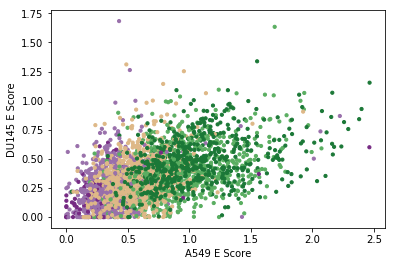

In [89]:
plt.scatter(best_E_Feature[A549_no_rev_index],A549_by_DU145_fit_E[A549_no_rev_index,1],s=10,c=A549_Reannot_norRev_colors)
plt.xlabel("A549 E Score")
plt.ylabel("DU145 E Score")

In [90]:
A549E_corr, A549E_pv = sp.stats.pearsonr(best_E_Feature[A549_no_rev_index],A549_by_DU145_fit_E[A549_no_rev_index,1])

print("Correlation of E-scores for A549 data:\t" + "{:.3}".format(A549E_corr) + " (" + "{:.3}".format(A549E_pv) + ")")

Correlation of E-scores for A549 data:	0.504 (1.78e-201)


Text(0, 0.5, 'DU145 M Score')

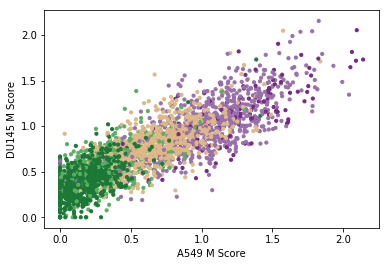

In [91]:
plt.scatter(best_M_Feature[A549_no_rev_index],A549_by_DU145_fit_M[A549_no_rev_index,1],s=10,c=A549_Reannot_norRev_colors)
plt.xlabel("A549 M Score")
plt.ylabel("DU145 M Score")

In [92]:
A549M_corr, A549M_pv = sp.stats.pearsonr(best_M_Feature[A549_no_rev_index],A549_by_DU145_fit_M[A549_no_rev_index,1])

print("Correlation of M-scores for A549 data:\t" + "{:.3}".format(A549M_corr) + " (" + "{:.3}".format(A549M_pv) + ")")

Correlation of M-scores for A549 data:	0.85 (0.0)


#### DU145 by A549

In [93]:
# Make refit model
model_E_refit = NMF(n_components=2, init='random', random_state=1001)
  
# E data: Train model
A549_W_E_refit = model_E_refit.fit_transform(A549_filter_values_E_array)
DU145_by_A549_fit_E = model_E_refit.transform(DU145_filter_values_E_array)

# Make refit model
model_M_refit = NMF(n_components=2, init='random', random_state=1001)

# M data: Train model
A549_W_M_refit = model_M_refit.fit_transform(A549_filter_values_M_array)
DU145_by_A549_fit_M = model_M_refit.transform(DU145_filter_values_M_array)

##### Compare to original A549

In [94]:
# Find the Leading Dimension by comparison to the original model
original_vs_refit0_E = np.corrcoef(A549_W_E_refit[:,0],best_E_Feature)[0,1]
original_vs_refit1_E = np.corrcoef(A549_W_E_refit[:,1],best_E_Feature)[0,1]
original_vs_refit0_M = np.corrcoef(A549_W_M_refit[:,0],best_M_Feature)[0,1]
original_vs_refit1_M = np.corrcoef(A549_W_M_refit[:,1],best_M_Feature)[0,1]

print("E-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_E))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_E))
print("")
print("M-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_M))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_M))

E-dimension
Original vs. 1st Refit Component:	-0.828
Original vs. 2nd Refit Component:	0.998

M-dimension
Original vs. 1st Refit Component:	-0.89
Original vs. 2nd Refit Component:	0.981


Text(0, 0.5, 'M Score')

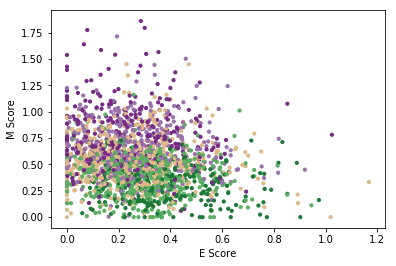

In [95]:
plt.scatter(DU145_by_A549_fit_E[DU145_no_rev_index,1],DU145_by_A549_fit_M[DU145_no_rev_index,1],s=10,c=DU145_Reannot_noRev_colors)
plt.xlabel("E Score")
plt.ylabel("M Score")

In [96]:
DU145_Reannot_time_noRev = [DU145_Reannot_time[v] for v in DU145_no_rev_index]
noRev_reg = LinearRegression().fit(np.array([DU145_by_A549_fit_E[DU145_no_rev_index,1], DU145_by_A549_fit_M[DU145_no_rev_index,1]]).transpose(), DU145_Reannot_time_noRev)
noRev_reg_R2 = noRev_reg.score(np.array([DU145_by_A549_fit_E[DU145_no_rev_index,1], DU145_by_A549_fit_M[DU145_no_rev_index,1]]).transpose(), DU145_Reannot_time_noRev)
print("DU145 by A549 Model Adjusted R2:\t" + "{:.3}".format(noRev_reg_R2))

DU145 by A549 Model Adjusted R2:	0.24


Text(0, 0.5, 'A549 E Score')

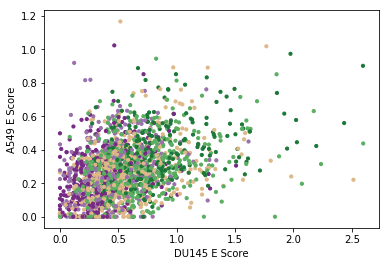

In [97]:
plt.scatter(W_E_train_DU145[DU145_no_rev_index,1],DU145_by_A549_fit_E[DU145_no_rev_index,1],s=10,c=DU145_Reannot_noRev_colors)
plt.xlabel("DU145 E Score")
plt.ylabel("A549 E Score")

In [98]:
DU145E_corr, DU145E_pv = sp.stats.pearsonr(W_E_train_DU145[DU145_no_rev_index,1],DU145_by_A549_fit_E[DU145_no_rev_index,1])

print("Correlation of E-scores for DU145 data:\t" + "{:.3}".format(DU145E_corr) + " (" + "{:.3}".format(DU145E_pv) + ")")

Correlation of E-scores for DU145 data:	0.388 (2.65e-73)


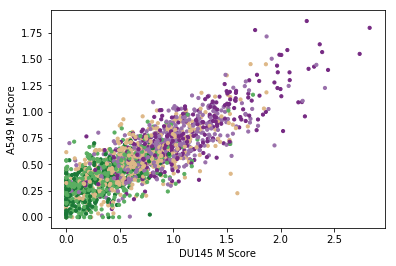

In [99]:
plt.scatter(W_M_train_DU145[DU145_no_rev_index,1],DU145_by_A549_fit_M[DU145_no_rev_index,1],s=10,c=DU145_Reannot_noRev_colors)
plt.xlabel("DU145 M Score")
plt.ylabel("A549 M Score")
plt.savefig("DU145_by_A549_Mscores.png")

In [100]:
DU145M_corr, DU145M_pv = sp.stats.pearsonr(W_M_train_DU145[DU145_no_rev_index,1],DU145_by_A549_fit_M[DU145_no_rev_index,1])
print("Correlation of M-scores for DU145 data:\t" + "{:.3}".format(DU145M_corr) + " (" + "{:.3}".format(DU145M_pv) + ")")

Correlation of M-scores for DU145 data:	0.832 (0.0)


## ------- TCGA Data -------

#### LUAD by A549

In [101]:
# Load pre-processed PRAD to reduce file size and memory useage
with open('array_A549_by_LUAD_Evalues_filter.pkl', 'rb') as handle:
    array_A549_by_LUAD_Evalues_filter = pickle.load(handle)
    
with open('LUAD_by_A549_filter_values_E_array.pkl', 'rb') as handle:
    LUAD_by_A549_filter_values_E_array = pickle.load(handle)
    
with open('LUAD_sample_names.pkl', 'rb') as handle:
    LUAD_sample_names = pickle.load(handle)

In [102]:
print(np.shape(array_A549_by_LUAD_Evalues_filter))
print(np.shape(LUAD_by_A549_filter_values_E_array))

(3568, 175)
(594, 175)


In [103]:
# Load pre-processed PRAD to reduce file size and memory useage
with open('array_A549_by_LUAD_Mvalues_filter.pkl', 'rb') as handle:
    array_A549_by_LUAD_Mvalues_filter = pickle.load(handle)
    
with open('LUAD_by_A549_filter_values_M_array.pkl', 'rb') as handle:
    LUAD_by_A549_filter_values_M_array = pickle.load(handle)
    

In [104]:
print(np.shape(array_A549_by_LUAD_Mvalues_filter))
print(np.shape(LUAD_by_A549_filter_values_M_array))

(3568, 114)
(594, 114)


In [105]:
# Make refit model
model_E_refit = NMF(n_components=2, init='random', random_state=1001)

# E data: Train model
A549_W_E_refit_for_LUAD = model_E_refit.fit_transform(array_A549_by_LUAD_Evalues_filter)
LUAD_by_A549_fit_E = model_E_refit.transform(LUAD_by_A549_filter_values_E_array)

# Make refit model
model_M_refit = NMF(n_components=2, init='random', random_state=1001)

# M data: Train model
A549_W_M_refit_for_LUAD = model_M_refit.fit_transform(array_A549_by_LUAD_Mvalues_filter)
LUAD_by_A549_fit_M = model_M_refit.transform(LUAD_by_A549_filter_values_M_array)

##### Check Refit Models

In [106]:
# Find the Leading Dimension by comparison to the original model
original_vs_refit0_E = np.corrcoef(A549_W_E_refit_for_LUAD[:,0],best_E_Feature)[0,1]
original_vs_refit1_E = np.corrcoef(A549_W_E_refit_for_LUAD[:,1],best_E_Feature)[0,1]
original_vs_refit0_M = np.corrcoef(A549_W_M_refit_for_LUAD[:,0],best_M_Feature)[0,1]
original_vs_refit1_M = np.corrcoef(A549_W_M_refit_for_LUAD[:,1],best_M_Feature)[0,1]

print("E-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_E))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_E))
print("")
print("M-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_M))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_M))

E-dimension
Original vs. 1st Refit Component:	-0.823
Original vs. 2nd Refit Component:	1.0

M-dimension
Original vs. 1st Refit Component:	-0.898
Original vs. 2nd Refit Component:	1.0


###  Process Data --- PRAD

#### PRAD by DU145

In [107]:
# Load pre-processed PRAD to reduce file size and memory useage
with open('array_DU145_by_PRAD_Evalues_filter.pkl', 'rb') as handle:
    array_DU145_by_PRAD_Evalues_filter = pickle.load(handle)
    
with open('PRAD_by_DU145_filter_values_E_array.pkl', 'rb') as handle:
    PRAD_by_DU145_filter_values_E_array = pickle.load(handle)

with open('PRAD_sample_names.pkl', 'rb') as handle:
    PRAD_sample_names = pickle.load(handle)

In [108]:
print(np.shape(array_DU145_by_PRAD_Evalues_filter))
print(np.shape(PRAD_by_DU145_filter_values_E_array))

(2853, 187)
(551, 187)


In [109]:
# Load pre-processed PRAD to reduce file size and memory useage
with open('array_DU145_by_PRAD_Mvalues_filter.pkl', 'rb') as handle:
    array_DU145_by_PRAD_Mvalues_filter = pickle.load(handle)
    
with open('PRAD_by_DU145_filter_values_M_array.pkl', 'rb') as handle:
    PRAD_by_DU145_filter_values_M_array = pickle.load(handle)
    

In [110]:
print(np.shape(array_DU145_by_PRAD_Mvalues_filter))
print(np.shape(PRAD_by_DU145_filter_values_M_array))

(2853, 114)
(551, 114)


In [111]:
# Make refit model
model_E_refit = NMF(n_components=2, init='random', random_state=1001)
    
# E data: Train model
DU145_W_E_refit_for_PRAD = model_E_refit.fit_transform(array_DU145_by_PRAD_Evalues_filter)
PRAD_by_DU145_fit_E = model_E_refit.transform(PRAD_by_DU145_filter_values_E_array)

# Make refit model
model_M_refit = NMF(n_components=2, init='random', random_state=1001)

# M data: Train model
DU145_W_M_refit_for_PRAD = model_M_refit.fit_transform(array_DU145_by_PRAD_Mvalues_filter)
PRAD_by_DU145_fit_M = model_M_refit.transform(PRAD_by_DU145_filter_values_M_array)

##### Check Refit Models

In [112]:
# Find the Leading Dimension by comparison to the original model
original_vs_refit0_E = np.corrcoef(W_E_train_DU145[:,DU145_best_E_index],DU145_W_E_refit_for_PRAD[:,0])[0,1]
original_vs_refit1_E = np.corrcoef(W_E_train_DU145[:,DU145_best_E_index],DU145_W_E_refit_for_PRAD[:,1])[0,1]
original_vs_refit0_M = np.corrcoef(W_M_train_DU145[:,DU145_best_M_index],DU145_W_M_refit_for_PRAD[:,0])[0,1]
original_vs_refit1_M = np.corrcoef(W_M_train_DU145[:,DU145_best_M_index],DU145_W_M_refit_for_PRAD[:,1])[0,1]

print("E-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_E))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_E))
print("")
print("M-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_M))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_M))

E-dimension
Original vs. 1st Refit Component:	-0.782
Original vs. 2nd Refit Component:	1.0

M-dimension
Original vs. 1st Refit Component:	-0.732
Original vs. 2nd Refit Component:	0.992


### LUAD by DU145

In [113]:
# Load pre-processed PRAD to reduce file size and memory useage
with open('array_DU145_by_LUAD_Evalues_filter.pkl', 'rb') as handle:
    array_DU145_by_LUAD_Evalues_filter = pickle.load(handle)
    
with open('LUAD_by_DU145_filter_values_E_array.pkl', 'rb') as handle:
    LUAD_by_DU145_filter_values_E_array = pickle.load(handle)
    

In [114]:
print(np.shape(array_DU145_by_LUAD_Evalues_filter))
print(np.shape(LUAD_by_DU145_filter_values_E_array))

(2853, 187)
(594, 187)


In [115]:
# Load pre-processed PRAD to reduce file size and memory useage
with open('array_DU145_by_LUAD_Mvalues_filter.pkl', 'rb') as handle:
    array_DU145_by_LUAD_Mvalues_filter = pickle.load(handle)
    
with open('LUAD_by_DU145_filter_values_M_array.pkl', 'rb') as handle:
    LUAD_by_DU145_filter_values_M_array = pickle.load(handle)
    

In [116]:
print(np.shape(array_DU145_by_LUAD_Mvalues_filter))
print(np.shape(LUAD_by_DU145_filter_values_M_array))

(2853, 114)
(594, 114)


In [117]:
# Make refit model
model_E_refit = NMF(n_components=2, init='random', random_state=1001)

# E data: Train model
DU145_W_E_refit_for_LUAD = model_E_refit.fit_transform(array_DU145_by_LUAD_Evalues_filter)
LUAD_by_DU145_fit_E = model_E_refit.transform(LUAD_by_DU145_filter_values_E_array)

# Make refit model
model_M_refit = NMF(n_components=2, init='random', random_state=1001)

# M data: Train model
DU145_W_M_refit_for_LUAD = model_M_refit.fit_transform(array_DU145_by_LUAD_Mvalues_filter)
LUAD_by_DU145_fit_M = model_M_refit.transform(LUAD_by_DU145_filter_values_M_array)

In [118]:
# Find the Leading Dimension by comparison to the original model
original_vs_refit0_E = np.corrcoef(W_E_train_DU145[:,DU145_best_E_index],DU145_W_E_refit_for_LUAD[:,0])[0,1]
original_vs_refit1_E = np.corrcoef(W_E_train_DU145[:,DU145_best_E_index],DU145_W_E_refit_for_LUAD[:,1])[0,1]
original_vs_refit0_M = np.corrcoef(W_M_train_DU145[:,DU145_best_M_index],DU145_W_M_refit_for_LUAD[:,0])[0,1]
original_vs_refit1_M = np.corrcoef(W_M_train_DU145[:,DU145_best_M_index],DU145_W_M_refit_for_LUAD[:,1])[0,1]

print("E-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_E))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_E))
print("")
print("M-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_M))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_M))

E-dimension
Original vs. 1st Refit Component:	-0.782
Original vs. 2nd Refit Component:	1.0

M-dimension
Original vs. 1st Refit Component:	-0.732
Original vs. 2nd Refit Component:	0.992


### PRAD by A549

In [119]:
# Load pre-processed PRAD to reduce file size and memory useage
with open('array_A549_by_PRAD_Evalues_filter.pkl', 'rb') as handle:
    array_A549_by_PRAD_Evalues_filter = pickle.load(handle)
    
with open('PRAD_by_A549_filter_values_E_array.pkl', 'rb') as handle:
    PRAD_by_A549_filter_values_E_array = pickle.load(handle)
    

In [120]:
print(np.shape(array_A549_by_PRAD_Evalues_filter))
print(np.shape(PRAD_by_A549_filter_values_E_array))

(3568, 175)
(551, 175)


In [121]:
# Load pre-processed PRAD to reduce file size and memory useage
with open('array_A549_by_PRAD_Mvalues_filter.pkl', 'rb') as handle:
    array_A549_by_PRAD_Mvalues_filter = pickle.load(handle)
    
with open('PRAD_by_A549_filter_values_M_array.pkl', 'rb') as handle:
    PRAD_by_A549_filter_values_M_array = pickle.load(handle)
    

In [122]:
print(np.shape(array_A549_by_PRAD_Mvalues_filter))
print(np.shape(PRAD_by_A549_filter_values_M_array))

(3568, 114)
(551, 114)


In [123]:
# Make refit model
model_E_refit = NMF(n_components=2, init='random', random_state=1001)
 
# E data: Train model
A549_W_E_refit_for_PRAD = model_E_refit.fit_transform(array_A549_by_PRAD_Evalues_filter)
PRAD_by_A549_fit_E = model_E_refit.transform(PRAD_by_A549_filter_values_E_array)

# Make refit model
model_M_refit = NMF(n_components=2, init='random', random_state=1001)
 
# M data: Train model
A549_W_M_refit_for_PRAD = model_M_refit.fit_transform(array_A549_by_PRAD_Mvalues_filter)
PRAD_by_A549_fit_M = model_M_refit.transform(PRAD_by_A549_filter_values_M_array)

In [124]:
# Find the Leading Dimension by comparison to the original model
original_vs_refit0_E = np.corrcoef(A549_W_E_refit_for_PRAD[:,0],best_E_Feature)[0,1]
original_vs_refit1_E = np.corrcoef(A549_W_E_refit_for_PRAD[:,1],best_E_Feature)[0,1]
original_vs_refit0_M = np.corrcoef(A549_W_M_refit_for_PRAD[:,0],best_M_Feature)[0,1]
original_vs_refit1_M = np.corrcoef(A549_W_M_refit_for_PRAD[:,1],best_M_Feature)[0,1]

print("E-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_E))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_E))
print("")
print("M-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_M))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_M))

E-dimension
Original vs. 1st Refit Component:	-0.823
Original vs. 2nd Refit Component:	1.0

M-dimension
Original vs. 1st Refit Component:	-0.898
Original vs. 2nd Refit Component:	1.0


### Compare to Previous Scores

##### LUAD Scores

In [125]:
# Make a dictionary of previous scores
LUAD_previous_values = [ln.strip() for ln in open("LUAD_GSAV.table.sample_names","r")]
LUAD_prev_values_dict = fm.PreviousValues_Lines2Dict(LUAD_previous_values)

In [126]:
# Align model with previous scores
output = fm.AlignScores (LUAD_sample_names, LUAD_prev_values_dict, LUAD_by_A549_fit_E[:,1], LUAD_by_A549_fit_M[:,1], LUAD_by_DU145_fit_E[:,1], LUAD_by_DU145_fit_M[:,1])

LUAD_by_A549_Escore = output[0]
LUAD_by_A549_Mscore = output[1]
LUAD_by_DU145_Escore = output[2]
LUAD_by_DU145_Mscore = output[3]
LUAD_previous_Escore = output[4]
LUAD_previous_Mscore = output[5]

##### Read in GSVA values for PRAD

In [127]:
# Make a dictionary of previous scores
PRAD_previous_values = [ln.strip() for ln in open("PRAD_Annot_Table.sample_names","r")]
PRAD_prev_values_dict = fm.PreviousValues_Lines2Dict(PRAD_previous_values)

In [128]:
# Align model with previous scores
output = fm.AlignScores (PRAD_sample_names, PRAD_prev_values_dict, PRAD_by_A549_fit_E[:,1], PRAD_by_A549_fit_M[:,1], PRAD_by_DU145_fit_E[:,1], PRAD_by_DU145_fit_M[:,1])

PRAD_by_A549_Escore = output[0]
PRAD_by_A549_Mscore = output[1]
PRAD_by_DU145_Escore = output[2]
PRAD_by_DU145_Mscore = output[3]
PRAD_previous_Escore = output[4]
PRAD_previous_Mscore = output[5]

### Compare Models

In [129]:
LUAD_by_A549_corr, LUAD_by_A549_pv = sp.stats.pearsonr(LUAD_by_A549_Escore,LUAD_previous_Escore)
print("LUAD Original vs A549 E Scores:\t" + "{:.3}".format(LUAD_by_A549_corr) + " (" + "{:.3}".format(LUAD_by_A549_pv) + ")" )

LUAD Original vs A549 E Scores:	0.763 (2.32e-110)


In [130]:
LUAD_by_DU145_corr, LUAD_by_DU145_pv = sp.stats.pearsonr(LUAD_by_DU145_Escore,LUAD_previous_Escore)
print("LUAD Original vs E DU145 Scores:\t" + "{:.3}".format(LUAD_by_DU145_corr) + " (" + "{:.3}".format(LUAD_by_DU145_pv) + ")" )

LUAD Original vs E DU145 Scores:	0.729 (3.27e-96)


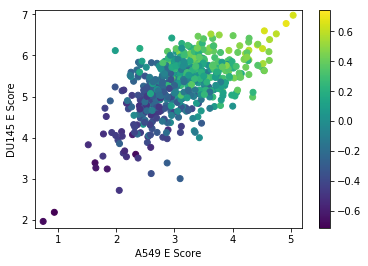

In [131]:
# spike in color balancing points
LUAD_by_A549_Escore.extend([0,0])
LUAD_by_DU145_Escore.extend([0,0])
LUAD_previous_Escore.extend([-0.714553652765244,0.74104974316114])

sc = plt.scatter(LUAD_by_A549_Escore,LUAD_by_DU145_Escore,c=LUAD_previous_Escore)
plt.xlim([0.6, 5.2])
plt.ylim([1.8, 7.1])
plt.xlabel("A549 E Score")
plt.ylabel("DU145 E Score")
plt.colorbar(sc)

In [132]:
LUAD_by_A549_corr, LUAD_by_A549_pv = sp.stats.pearsonr(LUAD_by_A549_Mscore,LUAD_previous_Mscore)
print("LUAD Original vs A549 M Scores:\t" + "{:.3}".format(LUAD_by_A549_corr) + " (" + "{:.3}".format(LUAD_by_A549_pv) + ")" )

LUAD Original vs A549 M Scores:	0.773 (7.41e-115)


In [133]:
LUAD_by_DU145_corr, LUAD_by_DU145_pv = sp.stats.pearsonr(LUAD_by_DU145_Mscore,LUAD_previous_Mscore)
print("LUAD Original vs DU145M Scores:\t" + "{:.3}".format(LUAD_by_DU145_corr) + " (" + "{:.3}".format(LUAD_by_DU145_pv) + ")" )

LUAD Original vs DU145M Scores:	0.747 (3.2e-103)


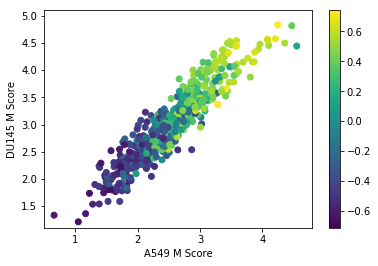

In [134]:
# spike in color balancing points
LUAD_by_A549_Mscore.extend([0,0])
LUAD_by_DU145_Mscore.extend([0,0])
LUAD_previous_Mscore.extend([-0.714553652765244,0.74104974316114])

sc = plt.scatter(LUAD_by_A549_Mscore,LUAD_by_DU145_Mscore,c=LUAD_previous_Mscore)
plt.xlim([0.5, 4.8])
plt.ylim([1.1, 5.1])
plt.xlabel("A549 M Score")
plt.ylabel("DU145 M Score")
plt.colorbar(sc)

In [135]:
PRAD_by_A549_corr, PRAD_by_A549_pv = sp.stats.pearsonr(PRAD_by_A549_Escore,PRAD_previous_Escore)
print("PRAD Original vs A549 E Scores:\t" + "{:.3}".format(PRAD_by_A549_corr) + " (" + "{:.3}".format(PRAD_by_A549_pv) + ")" )

PRAD Original vs A549 E Scores:	0.593 (2.09e-53)


In [136]:
PRAD_by_DU145_corr, PRAD_by_DU145_pv = sp.stats.pearsonr(PRAD_by_DU145_Escore,PRAD_previous_Escore)
print("PRAD Original vs DU145 E Scores:\t" + "{:.3}".format(PRAD_by_DU145_corr) + " (" + "{:.3}".format(PRAD_by_DU145_pv) + ")" )

PRAD Original vs DU145 E Scores:	0.603 (1.25e-55)


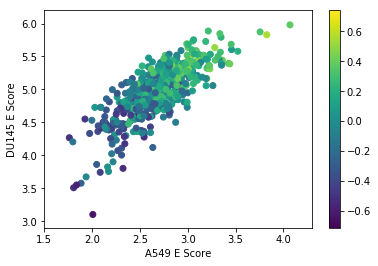

In [137]:
# spike in color balancing point
PRAD_by_DU145_Escore.extend([0,0])
PRAD_by_A549_Escore.extend([0,0])
PRAD_previous_Escore.extend([-0.714553652765244,0.74104974316114])

sc = plt.scatter(PRAD_by_A549_Escore,PRAD_by_DU145_Escore,c=PRAD_previous_Escore)
plt.xlim([1.5, 4.3])
plt.ylim([2.9, 6.2])
plt.xlabel("A549 E Score")
plt.ylabel("DU145 E Score")
plt.colorbar(sc)

In [138]:
PRAD_by_A549_corr, PRAD_by_A549_pv = sp.stats.pearsonr(PRAD_by_A549_Mscore,PRAD_previous_Mscore)
print("PRAD Original vs A549 M Scores:\t" + "{:.3}".format(PRAD_by_A549_corr) + " (" + "{:.3}".format(PRAD_by_A549_pv) + ")" )


PRAD Original vs A549 M Scores:	0.873 (1.65e-172)


In [139]:
PRAD_by_DU145_corr, PRAD_by_DU145_pv = sp.stats.pearsonr(PRAD_by_DU145_Mscore,PRAD_previous_Mscore)
print("PRAD Original vs DU145 M Scores:\t" + "{:.3}".format(PRAD_by_DU145_corr) + " (" + "{:.3}".format(PRAD_by_DU145_pv) + ")" )

PRAD Original vs DU145 M Scores:	0.858 (7.38e-160)


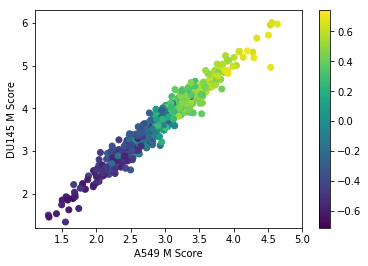

In [140]:
# spike in color balancing point
PRAD_by_DU145_Mscore.extend([0,0])
PRAD_by_A549_Mscore.extend([0,0])
PRAD_previous_Mscore.extend([-0.714553652765244,0.74104974316114])

sc = plt.scatter(PRAD_by_A549_Mscore,PRAD_by_DU145_Mscore,c=PRAD_previous_Mscore)
plt.xlim([1.1, 5.0])
plt.ylim([1.2, 6.3])
plt.xlabel("A549 M Score")
plt.ylabel("DU145 M Score")
plt.colorbar(sc)
#plt.savefig("PRAD_M_AllThreeMeasures.png")
#plt.savefig("Figure4_PanelC_PRAD_M_AllThreeMeasures.pdf")

## -------- Mock by TGFB -------

#### Process Data

In [141]:
# Read in Mock and TGFB data
# Note: The minimum has not be subtracted from this data, so we will do that when making the models
Mock_Egenes_lines = [ln.strip() for ln in open("Mock_LogTPM_E_transpose_scale.out.csv","r").readlines()]
Mock_Esamples, Mock_Evalues = fm.Process_scRNA_CSV(Mock_Egenes_lines)
Mock_Mgenes_lines = [ln.strip() for ln in open("Mock_LogTPM_M_transpose_scale.out.csv","r").readlines()]
Mock_Msamples, Mock_Mvalues = fm.Process_scRNA_CSV(Mock_Mgenes_lines)

TGFB1_Egenes_lines = [ln.strip() for ln in open("TGFB1_LogTPM_E_transpose_scale.out.csv","r").readlines()]
TGFB1_Esamples, TGFB1_Evalues = fm.Process_scRNA_CSV(TGFB1_Egenes_lines)
TGFB1_Mgenes_lines = [ln.strip() for ln in open("TGFB1_LogTPM_M_transpose_scale.out.csv","r").readlines()]
TGFB1_Msamples, TGFB1_Mvalues = fm.Process_scRNA_CSV(TGFB1_Mgenes_lines)

In [142]:
print(np.array(Mock_Evalues).shape)
print(np.array(Mock_Mvalues).shape)

(5027, 192)
(5027, 90)


In [143]:
print(np.array(TGFB1_Evalues).shape)
print(np.array(TGFB1_Mvalues).shape)

(4241, 177)
(4241, 108)


In [144]:
# Read annotation data
Mock_annotation = [ln.strip() for ln in open("Mock_InOut_annot.txt.fixed_name","r")]
TGFB_annotation = [ln.strip() for ln in open("TGFB_InOut_annot.txt.fixed_name","r")]

In [145]:
# Get positions and colors of inner and outer points
Mock_InOut = [ln.split("\t")[-1] for ln in Mock_annotation]
TGFB_InOut = [ln.split("\t")[-1] for ln in TGFB_annotation]

Mock_Idxs_inner = [i for i in range(len(Mock_InOut)) if Mock_InOut[i] == 'inner']
Mock_Idxs_outer = [i for i in range(len(Mock_InOut)) if Mock_InOut[i] == 'outer']
TGFB_Idxs_inner = [i for i in range(len(TGFB_InOut)) if TGFB_InOut[i] == 'inner']
TGFB_Idxs_outer = [i for i in range(len(TGFB_InOut)) if TGFB_InOut[i] == 'outer']

Mock_colors = fm.Position_to_Color(Mock_InOut)
TGFB_colors = fm.Position_to_Color(TGFB_InOut)

In [146]:
# Get gene names
Mock_Egenes = [v.strip('"') for v in Mock_Egenes_lines[0].split(",")][1:]
MocK_Mgenes = [v.strip('"') for v in Mock_Mgenes_lines[0].split(",")][1:]
TGFB1_Egenes = [v.strip('"') for v in TGFB1_Egenes_lines[0].split(",")][1:]
TGFB1_Mgenes = [v.strip('"') for v in TGFB1_Mgenes_lines[0].split(",")][1:]

### Mock

##### Check Consistency

In [147]:
W_E_PCC, W_M_PCC = fm.CheckSeedConsistency(Mock_Evalues-np.amin(Mock_Evalues),Mock_Mvalues-np.amin(Mock_Mvalues))
print("Mean W_E Corr:" + "\t" + str(np.mean(W_E_PCC)))
print("Mean W_M Corr:" + "\t" + str(np.mean(W_M_PCC)))

Mean W_E Corr:	0.9984448390401685
Mean W_M Corr:	0.9980286285720956


#### Base Model

In [148]:
# Make base model
model_E = NMF(n_components=2, init='random', random_state=1001)

# E data: Train model
W_E_train_Mock = model_E.fit_transform(Mock_Evalues-np.amin(Mock_Evalues))
Mock_H_E_train = model_E.components_

# Make base model
model_M = NMF(n_components=2, init='random', random_state=1001)

# M data: Train model
W_M_train_Mock = model_M.fit_transform(Mock_Mvalues-np.amin(Mock_Mvalues))
Mock_H_M_train = model_M.components_

In [149]:
Mock_BestFeature_E, Mock_pv_E, Mock_f_E, Mock_index_E = fm.Best_EFeature_InOut(W_E_train_Mock,Mock_Idxs_inner,Mock_Idxs_outer)
print("Best E dimension:\t" + "{:.3}".format(Mock_f_E) + " (" + "{:.3}".format(Mock_pv_E) + ", index=" + str(Mock_index_E) + ")")

Best E dimension:	0.669 (5.09e-96, index=0)


In [150]:
Mock_BestFeature_M, Mock_pv_M, Mock_f_M,  Mock_index_M = fm.Best_MFeature_InOut(W_M_train_Mock,Mock_Idxs_inner,Mock_Idxs_outer)
print("Best M dimension:\t" + "{:.3}".format(Mock_f_M) + " (" + "{:.3}".format(Mock_pv_M) + ", index=" + str(Mock_index_M) + ")")

Best M dimension:	0.803 (1.2e-303, index=1)


Text(0, 0.5, 'M Score')

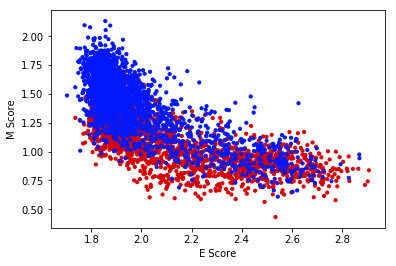

In [151]:
plt.scatter(Mock_BestFeature_E,Mock_BestFeature_M,s=10,c=Mock_colors)
plt.xlabel("E Score")
plt.ylabel("M Score")

In [152]:
# Save H martacies for later comparison
Mock_H_E_dict = {}
Mock_H_M_dict = {}

for E_index in range(len(Mock_Egenes)):
    Mock_H_E_dict[Mock_Egenes[E_index]] = Mock_H_E_train[0,E_index]
    
for M_index in range(len(MocK_Mgenes)):
    Mock_H_M_dict[MocK_Mgenes[M_index]] = Mock_H_M_train[1,M_index]

### TGFB

##### Check Consistency

In [153]:
W_E_PCC, W_M_PCC = fm.CheckSeedConsistency(TGFB1_Evalues-np.amin(TGFB1_Evalues),TGFB1_Mvalues-np.amin(TGFB1_Mvalues))
print("Mean W_E Corr:" + "\t" + str(np.mean(W_E_PCC)))
print("Mean W_M Corr:" + "\t" + str(np.mean(W_M_PCC)))


Mean W_E Corr:	0.9932611745707722
Mean W_M Corr:	0.4412154108145596


##### Increase Convergecne Paramters

In [154]:
W_E_PCC, W_M_PCC = fm.CheckSeedConsistency(TGFB1_Evalues-np.amin(TGFB1_Evalues),TGFB1_Mvalues-np.amin(TGFB1_Mvalues),tol=1e-9,iter=2500)
print("Mean W_E Corr:" + "\t" + str(np.mean(W_E_PCC)))
print("Mean W_M Corr:" + "\t" + str(np.mean(W_M_PCC)))


Mean W_E Corr:	0.9970391226329363
Mean W_M Corr:	0.9982113750012483


In [155]:
# Make base model
model_E_long = NMF(n_components=2, init='random', random_state=1001,tol=1e-9, max_iter=2500)

# E data: Train model
W_E_train_TGFB_long = model_E_long.fit_transform(TGFB1_Evalues-np.amin(TGFB1_Evalues))
TGFB1_H_E_train_long = model_E_long.components_

# Make base model
model_M_long = NMF(n_components=2, init='random', random_state=1001,tol=1e-9, max_iter=2500)
   
# M data: Train model
W_M_train_TGFB_long = model_M_long.fit_transform(TGFB1_Mvalues-np.amin(TGFB1_Mvalues))
TGFB1_H_M_train_long = model_M_long.components_

In [156]:
TGFB_BestFeature_E, TGFB_pv_E, TGFB_f_E,  TGFB_index_E = fm.Best_EFeature_InOut(W_E_train_TGFB_long,TGFB_Idxs_inner,TGFB_Idxs_outer)
print("Best E dimension:\t" + "{:.3}".format(TGFB_f_E) + " (" + "{:.3}".format(TGFB_pv_E) + ", index=" + str(TGFB_index_E) + ")")

Best E dimension:	0.863 (0.0, index=1)


In [157]:
TGFB_BestFeature_M, TGFB_pv_M, TGFB_f_M, TGFB_index_M = fm.Best_MFeature_InOut(W_M_train_TGFB_long,TGFB_Idxs_inner,TGFB_Idxs_outer)
print("Best M dimension:\t" + "{:.3}".format(TGFB_f_M) + " (" + "{:.3}".format(TGFB_pv_M) + ", index=" + str(TGFB_index_M) + ")")

Best M dimension:	0.855 (0.0, index=1)


Text(0, 0.5, 'M Score')

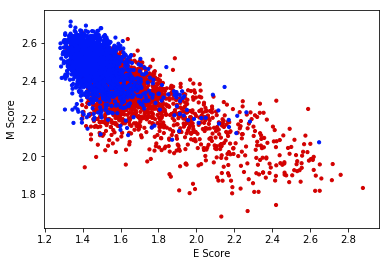

In [158]:
plt.scatter(W_E_train_TGFB_long[:,1],W_M_train_TGFB_long[:,1],s=10,c=TGFB_colors)
plt.xlabel("E Score")
plt.ylabel("M Score")

In [159]:
# Save H matracies for later
TGFB1_H_E_dict = {}
TGFB1_H_M_dict = {}

for E_index in range(len(TGFB1_Egenes)):
    TGFB1_H_E_dict[TGFB1_Egenes[E_index]] = TGFB1_H_E_train_long[1,E_index]
    
for M_index in range(len(TGFB1_Mgenes)):
    TGFB1_H_M_dict[TGFB1_Mgenes[M_index]] = TGFB1_H_M_train_long[1,M_index]

### Mock X TGFB1

#### Filter Data Sets

In [160]:
Mock_filter_values_E_array, TGFB1_filter_values_E_array, Mock_TGFB1_Egenes = fm.FilterDataByGenes_scRNA(Mock_Evalues,Mock_Egenes,TGFB1_Evalues,TGFB1_Egenes)

In [161]:
print(np.shape(Mock_filter_values_E_array))
print(np.shape(TGFB1_filter_values_E_array))

(5027, 175)
(4241, 175)


In [162]:
Mock_filter_values_M_array, TGFB1_filter_values_M_array, Mock_TGFB1_Mgenes = fm.FilterDataByGenes_scRNA(Mock_Mvalues,MocK_Mgenes,TGFB1_Mvalues,TGFB1_Mgenes)

In [163]:
print(np.shape(Mock_filter_values_M_array))
print(np.shape(TGFB1_filter_values_M_array))

(5027, 89)
(4241, 89)


#### Mock by TGFB

In [164]:
# Make refit model
model_E_refit = NMF(n_components=2, init='random', random_state=1001,tol=1e-9, max_iter=2500)
    
# E data: Train model
TGFB_W_E_refit = model_E_refit.fit_transform(TGFB1_filter_values_E_array-np.amin(TGFB1_filter_values_E_array))
Mock_by_TGFB1_H_E_refit = model_E_refit.components_
Mock_by_TGFB1_fit_E = model_E_refit.transform(Mock_filter_values_E_array-np.amin(Mock_filter_values_E_array))

# Make refit model
model_M_refit = NMF(n_components=2, init='random', random_state=1001,tol=1e-9, max_iter=2500)

# M data: Train model
TGFB_W_M_refit = model_M_refit.fit_transform(TGFB1_filter_values_M_array-np.amin(TGFB1_filter_values_M_array))
Mock_by_TGFB1_H_M_refit = model_M_refit.components_
Mock_by_TGFB1_fit_M = model_M_refit.transform(Mock_filter_values_M_array-np.amin(Mock_filter_values_M_array))

##### Check against original

In [165]:
# Find the Leading Dimension by comparison to the original model
original_vs_refit0_E = np.corrcoef(W_E_train_TGFB_long[:,1],TGFB_W_E_refit[:,0])[0,1]
original_vs_refit1_E = np.corrcoef(W_E_train_TGFB_long[:,1],TGFB_W_E_refit[:,1])[0,1]
original_vs_refit0_M = np.corrcoef(W_M_train_TGFB_long[:,1],TGFB_W_M_refit[:,0])[0,1]
original_vs_refit1_M = np.corrcoef(W_M_train_TGFB_long[:,1],TGFB_W_M_refit[:,1])[0,1]

print("E-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_E))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_E))
print("")
print("M-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_M))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_M))

E-dimension
Original vs. 1st Refit Component:	1.0
Original vs. 2nd Refit Component:	-0.866

M-dimension
Original vs. 1st Refit Component:	0.994
Original vs. 2nd Refit Component:	-0.896


Text(0, 0.5, 'M Score')

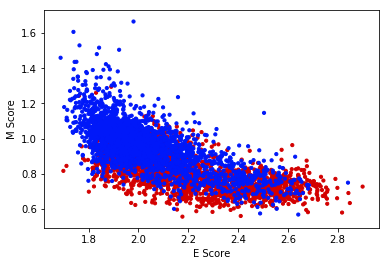

In [166]:
plt.scatter(Mock_by_TGFB1_fit_E[:,0],Mock_by_TGFB1_fit_M[:,0],s=10,c=Mock_colors)
plt.xlabel("E Score")
plt.ylabel("M Score")

In [167]:
stat, pv = sp.stats.mannwhitneyu(Mock_by_TGFB1_fit_E[Mock_Idxs_inner,0],Mock_by_TGFB1_fit_E[Mock_Idxs_outer,0],alternative='greater')
f_prob = stat/(len(Mock_Idxs_inner)*len(Mock_Idxs_outer))
print("Best E dimension:\t" + "{:.3}".format(f_prob) + " (" + "{:.3}".format(pv) + ")")

Best E dimension:	0.667 (2.99e-93)


In [168]:
stat, pv = sp.stats.mannwhitneyu(Mock_by_TGFB1_fit_M[Mock_Idxs_outer,0],Mock_by_TGFB1_fit_M[Mock_Idxs_inner,0],alternative='greater')
f_prob = stat/(len(Mock_Idxs_inner)*len(Mock_Idxs_outer))
print("Best M dimension:\t" + "{:.3}".format(f_prob) + " (" + "{:.3}".format(pv) + ")")

Best M dimension:	0.776 (3.61e-252)


#### TGFB1 by Mock

In [169]:
# Make refit model
model_E_refit = NMF(n_components=2, init='random', random_state=1001)
 
# E data: Train model
Mock_W_E_refit = model_E_refit.fit_transform(Mock_filter_values_E_array-np.amin(Mock_filter_values_E_array))
TGFB1_by_Mock_H_E_refit = model_E_refit.components_
TGFB1_by_Mock_fit_E = model_E_refit.transform(TGFB1_filter_values_E_array-np.amin(TGFB1_filter_values_E_array))

# Make refit model
model_M_refit = NMF(n_components=2, init='random', random_state=1001)

# M data: Train model
Mock_W_M_refit = model_M_refit.fit_transform(Mock_filter_values_M_array-np.amin(Mock_filter_values_M_array))
TGFB1_by_Mock_H_M_refit = model_M_refit.components_
TGFB1_by_Mock_fit_M = model_M_refit.transform(TGFB1_filter_values_M_array-np.amin(TGFB1_filter_values_M_array))

In [170]:
# Find the Leading Dimension by comparison to the original model
original_vs_refit0_E = np.corrcoef(W_E_train_Mock[:,0],Mock_W_E_refit[:,0])[0,1]
original_vs_refit1_E = np.corrcoef(W_E_train_Mock[:,0],Mock_W_E_refit[:,1])[0,1]
original_vs_refit0_M = np.corrcoef(W_M_train_Mock[:,1],Mock_W_M_refit[:,0])[0,1]
original_vs_refit1_M = np.corrcoef(W_M_train_Mock[:,1],Mock_W_M_refit[:,1])[0,1]

print("E-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_E))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_E))
print("")
print("M-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_M))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_M))

E-dimension
Original vs. 1st Refit Component:	0.996
Original vs. 2nd Refit Component:	-0.885

M-dimension
Original vs. 1st Refit Component:	0.999
Original vs. 2nd Refit Component:	-0.927


Text(0, 0.5, 'M Score')

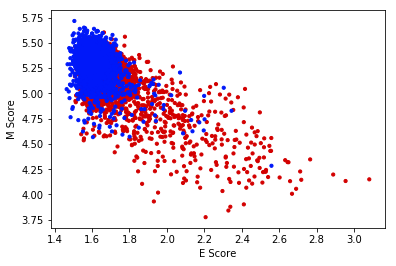

In [171]:
plt.scatter(TGFB1_by_Mock_fit_E[:,0],TGFB1_by_Mock_fit_M[:,0],s=10,c=TGFB_colors)
plt.xlabel("E Score")
plt.ylabel("M Score")

In [172]:
stat, pv = sp.stats.mannwhitneyu(TGFB1_by_Mock_fit_E[TGFB_Idxs_inner,0],TGFB1_by_Mock_fit_E[TGFB_Idxs_outer,0],alternative='greater')
f_prob = stat/(len(TGFB_Idxs_inner)*len(TGFB_Idxs_outer))
print("Best E dimension:\t" + "{:.3}".format(f_prob) + " (" + "{:.3}".format(pv) + ")")

Best E dimension:	0.772 (2.17e-206)


In [173]:
stat, pv = sp.stats.mannwhitneyu(TGFB1_by_Mock_fit_M[TGFB_Idxs_outer,0],TGFB1_by_Mock_fit_M[TGFB_Idxs_inner,0],alternative='greater')
AUCROC = stat/(len(TGFB_Idxs_inner)*len(TGFB_Idxs_outer))
print("Best M dimension:\t" + "{:.3}".format(f_prob) + " (" + "{:.3}".format(pv) + ")")

Best M dimension:	0.772 (9.83e-152)


### -----A549 X Spatial-----

#### Mock by A549

In [174]:
A549_filter_values_E_array, Mock_filter_values_E_array, A549_by_Mock_Egenes = fm.FilterDataByGenes_scRNA(A549_Evalues,A549_Egenes,Mock_Evalues,Mock_Egenes)

In [175]:
print(np.shape(A549_filter_values_E_array))
print(np.shape(Mock_filter_values_E_array))

(3568, 163)
(5027, 163)


In [176]:
A549_filter_values_M_array, Mock_filter_values_M_array, A549_by_Mock_Mgenes  = fm.FilterDataByGenes_scRNA(A549_Mvalues,A549_Mgenes,Mock_Mvalues,MocK_Mgenes)

In [177]:
print(np.shape(A549_filter_values_M_array))
print(np.shape(Mock_filter_values_M_array))

(3568, 77)
(5027, 77)


In [178]:
# Make refit model
model_E_refit = NMF(n_components=2, init='random', random_state=1001)

# E data: Train model
A549_W_E_refit_for_Mock = model_E_refit.fit_transform(A549_filter_values_E_array)
Mock_by_A549_H_E_refit = model_E_refit.components_
Mock_by_A549_fit_E = model_E_refit.transform(Mock_filter_values_E_array-np.amin(Mock_filter_values_E_array))

# Make refit model
model_M_refit = NMF(n_components=2, init='random', random_state=1001)

# M data: Train model
A549_W_M_refit_for_Mock  = model_M_refit.fit_transform(A549_filter_values_M_array)
Mock_by_A549_H_M_refit = model_M_refit.components_
Mock_by_A549_fit_M = model_M_refit.transform(Mock_filter_values_M_array-np.amin(Mock_filter_values_M_array))

In [179]:
# Find the Leading Dimension by comparison to the original model
original_vs_refit0_E = np.corrcoef(best_E_Feature,A549_W_E_refit_for_Mock[:,0])[0,1]
original_vs_refit1_E = np.corrcoef(best_E_Feature,A549_W_E_refit_for_Mock[:,1])[0,1]
original_vs_refit0_M = np.corrcoef(best_M_Feature,A549_W_M_refit_for_Mock[:,0])[0,1]
original_vs_refit1_M = np.corrcoef(best_M_Feature,A549_W_M_refit_for_Mock[:,1])[0,1]

print("E-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_E))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_E))
print("")
print("M-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_M))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_M))

E-dimension
Original vs. 1st Refit Component:	-0.806
Original vs. 2nd Refit Component:	0.981

M-dimension
Original vs. 1st Refit Component:	-0.883
Original vs. 2nd Refit Component:	0.98


Text(0, 0.5, 'M Score')

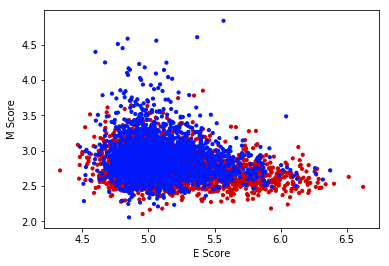

In [180]:
plt.scatter(Mock_by_A549_fit_E[:,1],Mock_by_A549_fit_M[:,1],s=10,c=Mock_colors)
plt.xlabel("E Score")
plt.ylabel("M Score")

In [181]:
stat, pv = sp.stats.mannwhitneyu(Mock_by_A549_fit_E[Mock_Idxs_inner,1],Mock_by_A549_fit_E[Mock_Idxs_outer,1])

# Need to manual corret this p-value, because the function likes to flip the sample if we set the alternative to greater
# Using no alternative gives us 1/2 the bi-directional p-value, so 1 - pv is the correct pv for f_prob < 0.5
pv = 1-pv
f_prob = stat/(len(Mock_Idxs_inner)*len(Mock_Idxs_outer))
print("Best E dimension:\t" + "{:.3}".format(f_prob) + " (" + "{:.3}".format(pv) + ")")

Best E dimension:	0.48 (0.994)


In [182]:
stat, pv = sp.stats.mannwhitneyu(Mock_by_A549_fit_M[Mock_Idxs_outer,1],Mock_by_A549_fit_M[Mock_Idxs_inner,1],alternative='greater')
f_prob = stat/(len(Mock_Idxs_inner)*len(Mock_Idxs_outer))
print("Best M dimension:\t" + "{:.3}".format(f_prob) + " (" + "{:.3}".format(pv) + ")")

Best M dimension:	0.638 (4.34e-65)


In [183]:
# Save H matracies for later analysis
Mock_by_A549_H_E_dict = {}
Mock_by_A549_H_M_dict = {}


for E_index in range(len(A549_by_Mock_Egenes)):
    Mock_by_A549_H_E_dict[A549_by_Mock_Egenes[E_index]] = Mock_by_A549_H_E_refit[1,E_index]
    
for M_index in range(len(A549_by_Mock_Mgenes)):
    Mock_by_A549_H_M_dict[A549_by_Mock_Mgenes[M_index]] = Mock_by_A549_H_M_refit[1,M_index]

#### A549 by TGFB

In [184]:
A549_filter_values_E_array, TGFB1_filter_values_E_array, A549_by_TGFB1_Egenes = fm.FilterDataByGenes_scRNA(A549_Evalues,A549_Egenes,TGFB1_Evalues,TGFB1_Egenes)

In [185]:
print(np.shape(A549_filter_values_E_array))
print(np.shape(TGFB1_filter_values_E_array))

(3568, 154)
(4241, 154)


In [186]:
A549_filter_values_M_array, TGFB1_filter_values_M_array, A549_by_TGFB1_Mgenes = fm.FilterDataByGenes_scRNA(A549_Mvalues,A549_Mgenes,TGFB1_Mvalues,TGFB1_Mgenes)

In [187]:
print(np.shape(A549_filter_values_M_array))
print(np.shape(TGFB1_filter_values_M_array))

(3568, 93)
(4241, 93)


In [188]:
# Make refit model
model_E_refit = NMF(n_components=2, init='random', random_state=1001)
  
# E data: Train model
A549_W_E_refit_for_TGFB1 = model_E_refit.fit_transform(A549_filter_values_E_array)
TGFB1_by_A549_H_E_refit = model_E_refit.components_
TGFB1_by_A549_fit_E = model_E_refit.transform(TGFB1_filter_values_E_array-np.amin(TGFB1_filter_values_E_array))

# Make refit model
model_M_refit = NMF(n_components=2, init='random', random_state=1001)
   
# M data: Train model
A549_W_M_refit_for_TGFB1 = model_M_refit.fit_transform(A549_filter_values_M_array)
TGFB1_by_A549_H_M_refit = model_M_refit.components_
TGFB1_by_A549_fit_M = model_M_refit.transform(TGFB1_filter_values_M_array-np.amin(TGFB1_filter_values_M_array))

In [189]:
# Find the Leading Dimension by comparison to the original model
original_vs_refit0_E = np.corrcoef(best_E_Feature,A549_W_E_refit_for_TGFB1[:,0])[0,1]
original_vs_refit1_E = np.corrcoef(best_E_Feature,A549_W_E_refit_for_TGFB1[:,1])[0,1]
original_vs_refit0_M = np.corrcoef(best_M_Feature,A549_W_M_refit_for_TGFB1[:,0])[0,1]
original_vs_refit1_M = np.corrcoef(best_M_Feature,A549_W_M_refit_for_TGFB1[:,1])[0,1]

print("E-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_E))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_E))
print("")
print("M-dimension")
print("Original vs. 1st Refit Component:\t" + "{:.3}".format(original_vs_refit0_M))
print("Original vs. 2nd Refit Component:\t" + "{:.3}".format(original_vs_refit1_M))

E-dimension
Original vs. 1st Refit Component:	-0.811
Original vs. 2nd Refit Component:	0.971

M-dimension
Original vs. 1st Refit Component:	-0.896
Original vs. 2nd Refit Component:	0.996


Text(0, 0.5, 'M Score')

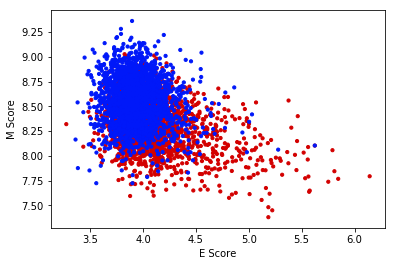

In [190]:
plt.scatter(TGFB1_by_A549_fit_E[:,1],TGFB1_by_A549_fit_M[:,1],s=10,c=TGFB_colors)
plt.xlabel("E Score")
plt.ylabel("M Score")

In [191]:
stat, pv = sp.stats.mannwhitneyu(TGFB1_by_A549_fit_E[TGFB_Idxs_inner,1],TGFB1_by_A549_fit_E[TGFB_Idxs_outer,1],alternative='greater')
f_prob = stat/(len(TGFB_Idxs_inner)*len(TGFB_Idxs_outer))


In [192]:
stat, pv = sp.stats.mannwhitneyu(TGFB1_by_A549_fit_M[TGFB_Idxs_outer,1],TGFB1_by_A549_fit_M[TGFB_Idxs_inner,1],alternative='greater')
f_prob = stat/(len(TGFB_Idxs_inner)*len(TGFB_Idxs_outer))
print("Best E dimension:\t" + "{:.3}".format(f_prob) + " (" + "{:.3}".format(pv) + ")")

Best E dimension:	0.757 (8.17e-185)


In [193]:
# Save H matracies for later analysis
TGFB1_by_A549_H_E_dict = {}
TGFB1_by_A549_H_M_dict = {}

for E_index in range(len(A549_by_TGFB1_Egenes)):
    TGFB1_by_A549_H_E_dict[A549_by_TGFB1_Egenes[E_index]] = TGFB1_by_A549_H_E_refit[1,E_index]
    
for M_index in range(len(A549_by_TGFB1_Mgenes)):
    TGFB1_by_A549_H_M_dict[A549_by_TGFB1_Mgenes[M_index]] = TGFB1_by_A549_H_M_refit[1,M_index]

### Compare Gene Ranks via H-mats

#### Mock vs A954

In [194]:
# Combine H mat dictionaries
Mock_E_combined_dict = fm.MergeDictionaries(Mock_H_E_dict,Mock_by_A549_H_E_dict)
Mock_M_combined_dict = fm.MergeDictionaries(Mock_H_M_dict,Mock_by_A549_H_M_dict)

In [195]:
# Get Loading values for E dimensions
Mock_by_Mock_Escores = [Mock_E_combined_dict[key]["Base"][0] for key in Mock_E_combined_dict.keys()]
Mock_by_A549_Escores = [Mock_E_combined_dict[key]["A549"][0] for key in Mock_E_combined_dict.keys()]

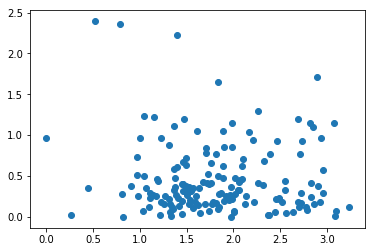

In [196]:
plt.scatter(Mock_by_Mock_Escores,Mock_by_A549_Escores)

In [197]:
Mock_vs_A549_E_corr, Mock_vs_A549_E_pv = sp.stats.pearsonr(Mock_by_Mock_Escores,Mock_by_A549_Escores)
print("E gene loading correlation:\t" + "{:.3}".format(Mock_vs_A549_E_corr) + " (" + "{:.3}".format(Mock_vs_A549_E_pv) + ")")

E gene loading correlation:	-0.0763 (0.333)


In [198]:
Mock_by_Mock_E = fm.GetGenes(Mock_E_combined_dict,"Base",np.percentile(Mock_by_Mock_Escores,90))
Mock_by_A549_E = fm.GetGenes(Mock_E_combined_dict,"A549",np.percentile(Mock_by_A549_Escores,90))
Mock_Common_E = set(Mock_by_Mock_E).intersection(Mock_by_A549_E)
print("E genes in the 90th percentile of Mock and A549")
Mock_Common_E

E genes in the 90th percentile of Mock and A549


{'ELF3', 'PERP', 'S100P', 'SLPI'}

In [199]:
# Get loading values for the M dimension
Mock_by_Mock_Mscores = [Mock_M_combined_dict[key]["Base"][0] for key in Mock_M_combined_dict.keys()]
Mock_by_A549_Mscores = [Mock_M_combined_dict[key]["A549"][0] for key in Mock_M_combined_dict.keys()]

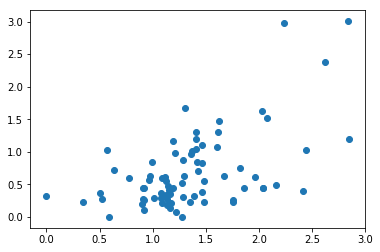

In [200]:
plt.scatter(Mock_by_Mock_Mscores,Mock_by_A549_Mscores)

In [201]:
Mock_vs_A549_M_corr, Mock_vs_A549_M_pv = sp.stats.pearsonr(Mock_by_Mock_Mscores,Mock_by_A549_Mscores)
print("M gene loading correlation:\t" + "{:.3}".format(Mock_vs_A549_M_corr) + " (" + "{:.3}".format(Mock_vs_A549_M_pv) + ")")

M gene loading correlation:	0.557 (1.4e-07)


In [202]:
Mock_by_Mock_M = fm.GetGenes(Mock_M_combined_dict,"Base",np.percentile(Mock_by_Mock_Mscores,90))
Mock_by_A549_M = fm.GetGenes(Mock_M_combined_dict,"A549",np.percentile(Mock_by_A549_Mscores,90))
Mock_Common_M = set(Mock_by_Mock_M).intersection(Mock_by_A549_M)
print("M genes in the 90th percentile of Mock and A549")
Mock_Common_M

M genes in the 90th percentile of Mock and A549


{'KRT8', 'LGALS1', 'TPM2', 'VIM'}

#### TGFB vs A549

In [203]:
# Combine H mat dictionaries
TGFB1_E_combined_dict = fm.MergeDictionaries(TGFB1_H_E_dict,TGFB1_by_A549_H_E_dict)
TGFB1_M_combined_dict = fm.MergeDictionaries(TGFB1_H_M_dict,TGFB1_by_A549_H_M_dict)

In [204]:
# Get Loading values for E dimensions
TGFB_by_TGFB_Escores = [TGFB1_E_combined_dict[key]["Base"][0] for key in TGFB1_E_combined_dict.keys()]
TGFB_by_A549_Escores = [TGFB1_E_combined_dict[key]["A549"][0] for key in TGFB1_E_combined_dict.keys()]

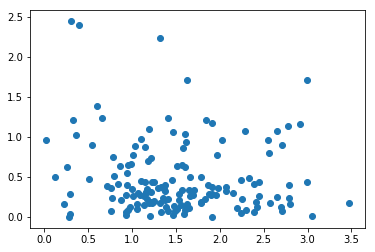

In [205]:
plt.scatter(TGFB_by_TGFB_Escores,TGFB_by_A549_Escores)

In [206]:
TGFB_vs_A549_E_corr, TGFB_vs_A549_E_pv = sp.stats.pearsonr(TGFB_by_TGFB_Escores,TGFB_by_A549_Escores)
print("E gene loading correlation:\t" + "{:.3}".format(TGFB_vs_A549_E_corr) + " (" + "{:.3}".format(TGFB_vs_A549_E_pv) + ")")

E gene loading correlation:	-0.104 (0.198)


In [207]:
TGFB_by_TGFB_E = fm.GetGenes(TGFB1_E_combined_dict,"Base",np.percentile(TGFB_by_TGFB_Escores,90))
TGFB_by_A549_E = fm.GetGenes(TGFB1_E_combined_dict,"A549",np.percentile(TGFB_by_A549_Escores,90))
TGFB_Common_E = set(TGFB_by_TGFB_E).intersection(TGFB_by_A549_E)
print("E genes in the 90th percentile of Mock and A549")
TGFB_Common_E

E genes in the 90th percentile of Mock and A549


{'ELF3', 'PERP', 'S100P', 'SLPI'}

In [208]:
# Get Loading values for M dimensions
TGFB_by_TGFB_Mscores = [TGFB1_M_combined_dict[key]["Base"][0] for key in TGFB1_M_combined_dict.keys()]
TGFB_by_A549_Mscores = [TGFB1_M_combined_dict[key]["A549"][0] for key in TGFB1_M_combined_dict.keys()]

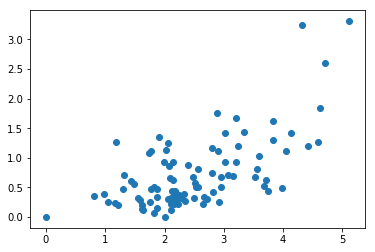

In [209]:
plt.scatter(TGFB_by_TGFB_Mscores,TGFB_by_A549_Mscores)

In [210]:
TGFB_vs_A549_M_corr, TGFB_vs_A549_M_pv = sp.stats.pearsonr(TGFB_by_TGFB_Mscores,TGFB_by_A549_Mscores)
print("M gene loading correlation:\t" + "{:.3}".format(TGFB_vs_A549_M_corr) + " (" + "{:.3}".format(TGFB_vs_A549_M_pv) + ")")

M gene loading correlation:	0.643 (3.61e-12)


In [211]:
TGFB_by_TGFB_M = fm.GetGenes(TGFB1_M_combined_dict,"Base",np.percentile(TGFB_by_TGFB_Mscores,90))
TGFB_by_A549_M = fm.GetGenes(TGFB1_M_combined_dict,"A549",np.percentile(TGFB_by_A549_Mscores,90))
TGFB_Common_M = set(TGFB_by_TGFB_M).intersection(TGFB_by_A549_M)
print("M genes in the 90th percentile of Mock and A549")
TGFB_Common_M

M genes in the 90th percentile of Mock and A549


{'GLIPR1', 'LGALS1', 'SERPINE1', 'TAGLN', 'TPM2', 'VIM'}

#### Compare

In [212]:
print("E genes in the 90th percentile of All Models")
set(TGFB_Common_E).intersection(Mock_Common_E)

E genes in the 90th percentile of All Models


{'ELF3', 'PERP', 'S100P', 'SLPI'}

In [213]:
print("M genes in the 90th percentile of All Models")
set(TGFB_Common_M).intersection(Mock_Common_M)

M genes in the 90th percentile of All Models


{'LGALS1', 'TPM2', 'VIM'}

##### Mock Down

In [214]:
print("E genes in 10th percentile of Mock, but the 90th percentile of A549")
Mock_by_Mock_E_Dn = fm.GetGenes_Down(Mock_E_combined_dict,"Base",np.percentile(Mock_by_Mock_Escores,10))
set(Mock_by_Mock_E_Dn).intersection(Mock_by_A549_E)

E genes in 10th percentile of Mock, but the 90th percentile of A549


{'ABCC3', 'KRT18', 'NQO1'}

In [215]:
print("E genes in 90th percentile of Mock, but the 10th percentile of A549")
Mock_by_A549_E_Dn = fm.GetGenes_Down(Mock_E_combined_dict,"A549",np.percentile(Mock_by_A549_Escores,10))
set(Mock_by_A549_E_Dn).intersection(Mock_by_Mock_E)

E genes in 90th percentile of Mock, but the 10th percentile of A549


{'DSC2'}

In [216]:
print("M genes in 10th percentile of Mock, but the 90th percentile of A549")
Mock_by_Mock_M_Dn = fm.GetGenes_Down(Mock_M_combined_dict,"Base",np.percentile(Mock_by_Mock_Mscores,10))
set(Mock_by_Mock_M_Dn).intersection(Mock_by_A549_M)

M genes in 10th percentile of Mock, but the 90th percentile of A549


set()

In [217]:
print("M genes in 90th percentile of Mock, but the 10th percentile of A549")
Mock_by_A549_M_Dn = fm.GetGenes_Down(Mock_M_combined_dict,"A549",np.percentile(Mock_by_A549_Mscores,10))
set(Mock_by_A549_M_Dn).intersection(Mock_by_Mock_M)

M genes in 90th percentile of Mock, but the 10th percentile of A549


set()

#### TGFb Down

In [218]:
print("E genes in 10th percentile of TGFB1, but the 90th percentile of A549")
TGFB_by_TGFB_E_Dn = fm.GetGenes_Down(TGFB1_E_combined_dict,"Base",np.percentile(TGFB_by_TGFB_Escores,10))
set(TGFB_by_TGFB_E_Dn).intersection(TGFB_by_A549_E)

E genes in 10th percentile of TGFB1, but the 90th percentile of A549


{'ABCC3', 'AREG', 'KRT18', 'KRT7', 'NQO1'}

In [219]:
print("E genes in 90th percentile of TGFB1, but the 10th percentile of A549")
TGFB_by_A549_E_Dn = fm.GetGenes_Down(TGFB1_E_combined_dict,"A549",np.percentile(TGFB_by_A549_Escores,10))
set(TGFB_by_A549_E_Dn).intersection(TGFB_by_TGFB_E)

E genes in 90th percentile of TGFB1, but the 10th percentile of A549


{'DSC2', 'PPL'}

In [220]:
print("M genes in 10th percentile of TGFB1, but the 90th percentile of A549")
TGFB_by_TGFB_M_Dn = fm.GetGenes_Down(TGFB1_M_combined_dict,"Base",np.percentile(TGFB_by_TGFB_Mscores,10))
set(TGFB_by_TGFB_M_Dn).intersection(TGFB_by_A549_M)

M genes in 10th percentile of TGFB1, but the 90th percentile of A549


set()

In [221]:
print("M genes in 90th percentile of TGFB1, but the 10th percentile of A549")
TGFB_by_A549_M_Dn = fm.GetGenes_Down(TGFB1_M_combined_dict,"A549",np.percentile(TGFB_by_A549_Mscores,10))
set(TGFB_by_A549_M_Dn).intersection(TGFB_by_TGFB_M)

M genes in 90th percentile of TGFB1, but the 10th percentile of A549


set()

## ------- C2 Gene Set Analysis -------

#### Load Data

In [222]:
# Load pre-processed C2 Modules
with open('random_convgergent_NMF_results_dict.pkl', 'rb') as handle:
    NMF_results_dict = pickle.load(handle)

### C2 Clusters

In [223]:
# Filter keys by percent variance relative to the mean
filtered_keys_005 = fm.Filter_C2Keys(NMF_results_dict)
print("Total filtered C2 Modules:" + str(len(filtered_keys_005)))

Total filtered C2 Modules:5120


In [224]:
SeedR2Correlation = fm.SeedR2Correlation(NMF_results_dict,filtered_keys_005)
print("Average Correlation of PCC values between seeds:\t" + "{:.3}".format(np.mean(SeedR2Correlation)))

Average Correlation of PCC values between seeds:	0.998


In [225]:
# Average PCC values across seeds
module_seedMEAN_PCC_dict = fm.AverageSeedPCCs(filtered_keys_005,NMF_results_dict)

In [226]:
# Split Positive and Negative Keys
postive_keys = [key for key in filtered_keys_005 if module_seedMEAN_PCC_dict[key]> 0.0]
negative_keys = [key for key in filtered_keys_005 if module_seedMEAN_PCC_dict[key] < 0.0]

#### Positively Correlated Modules

In [227]:
# These values are the same across all seeds
positive_GeneCount = [NMF_results_dict[1001][key]["N"] for key in postive_keys]
positive_MgeneCount = [NMF_results_dict[1001][key]["M_count"] for key in postive_keys]
# These values are averaged across seeds
positive_PCC = [module_seedMEAN_PCC_dict[key] for key in postive_keys]

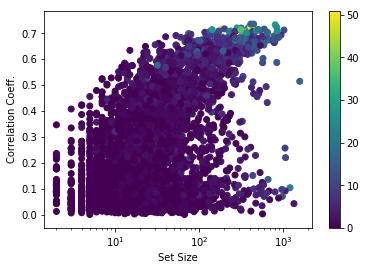

In [228]:
sc = plt.scatter(positive_GeneCount,positive_PCC,c=positive_MgeneCount)
plt.xscale('log')
plt.xlabel("Set Size")
plt.ylabel("Correlation Coeff.")
plt.colorbar(sc)

In [229]:
print("Positively Correlated Modules:\t" + "{:}".format(len(positive_GeneCount)))
pos_M_pcc, pos_M_pv = sp.stats.pearsonr(positive_MgeneCount,positive_PCC)
print("Correlation of M gene count and module PCC:\t" + "{:.3}".format(pos_M_pcc) + " (" + "{:.3}".format(pos_M_pv) + ")")

Positively Correlated Modules:	3887
Correlation of M gene count and module PCC:	0.545 (7.21e-300)


#### Negatively Correlated Modules

In [230]:
# These values are the same across all seeds
negative_GeneCount = [NMF_results_dict[1001][key]["N"] for key in negative_keys]
negative_EgeneCount = [NMF_results_dict[1001][key]["E_count"] for key in negative_keys]
# These values are averaged across seeds
negative_PCC_R = [module_seedMEAN_PCC_dict[key] for key in negative_keys]

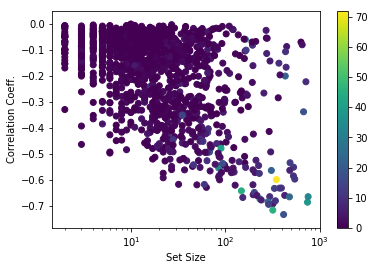

In [231]:
sc = plt.scatter(negative_GeneCount,negative_PCC_R,c=negative_EgeneCount)
plt.xscale('log')
plt.xlabel("Set Size")
plt.ylabel("Correlation Coeff.")
plt.colorbar(sc)

In [232]:
print("Positively Correlated Modules:\t" + "{:}".format(len(negative_GeneCount)))
pos_E_pcc, pos_E_pv = sp.stats.pearsonr(negative_EgeneCount,negative_PCC_R)
print("Correlation of E gene count and module PCC:\t" + "{:.3}".format(pos_E_pcc) + " (" + "{:.3}".format(pos_E_pv) + ")")

Positively Correlated Modules:	1233
Correlation of E gene count and module PCC:	-0.453 (1.75e-63)


### Denovo Cluster

In [242]:
# Load pre-processed Denovo-clusters
with open('denovo_modulesout_dict.pkl', 'rb') as handle:
    out_dict = pickle.load(handle)

with open('gene_values_dict.pkl', 'rb') as handle:
    gene_values_dict = pickle.load(handle)
    
with open('gene_modules_dict.pkl', 'rb') as handle:
    gene_modules_dict = pickle.load(handle)

In [243]:
min_corr_00_N = []
min_corr_01_N = []
min_corr_02_N = []
min_corr_03_N = []
min_corr_04_N = []
min_corr_05_N = []
min_corr_00 = []
min_corr_01 = []
min_corr_02 = []
min_corr_03 = []
min_corr_04 = []
min_corr_05 = []

min_corr_values = [0.0,0.1,0.2,0.3,0.4,0.5]
percentile_values = [80,85,90,95,98,99,99.5]

for percentile in percentile_values:
    min_corr_00_N.append(len(gene_modules_dict[0.0][percentile]))
    min_corr_00.append(np.mean(out_dict[0.0][percentile]))
    
for percentile in percentile_values:
    min_corr_01_N.append(len(gene_modules_dict[0.1][percentile]))
    min_corr_01.append(np.mean(out_dict[0.1][percentile]))

for percentile in percentile_values:
    min_corr_02_N.append(len(gene_modules_dict[0.2][percentile]))
    min_corr_02.append(np.mean(out_dict[0.2][percentile]))
    
for percentile in percentile_values:
    min_corr_03_N.append(len(gene_modules_dict[0.3][percentile]))
    min_corr_03.append(np.mean(out_dict[0.3][percentile]))
    
for percentile in percentile_values:
    min_corr_04_N.append(len(gene_modules_dict[0.4][percentile]))
    min_corr_04.append(np.mean(out_dict[0.4][percentile]))
    
for percentile in percentile_values:
    min_corr_05_N.append(len(gene_modules_dict[0.5][percentile]))
    min_corr_05.append(np.mean(out_dict[0.5][percentile]))


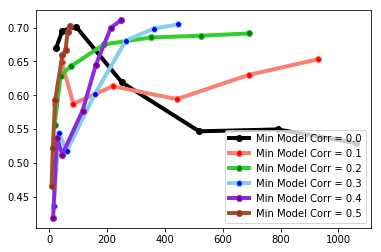

In [244]:
plt.plot(min_corr_00_N,min_corr_00, marker='.', markerfacecolor='black', markersize=12, color='black', linewidth=4,label="Min Model Corr = 0.0")
plt.plot(min_corr_01_N,min_corr_01, marker='.', markerfacecolor='red', markersize=12, color='salmon', linewidth=4,label="Min Model Corr = 0.1")
plt.plot(min_corr_02_N,min_corr_02, marker='.', markerfacecolor='green', markersize=12, color='limegreen', linewidth=4,label="Min Model Corr = 0.2")
plt.plot(min_corr_03_N,min_corr_03, marker='.', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label="Min Model Corr = 0.3")
plt.plot(min_corr_04_N,min_corr_04, marker='.', markerfacecolor='purple', markersize=12, color='blueviolet', linewidth=4,label="Min Model Corr = 0.4")
plt.plot(min_corr_05_N,min_corr_05, marker='.', markerfacecolor='brown', markersize=12, color='sienna', linewidth=4,label="Min Model Corr = 0.5")

plt.legend()

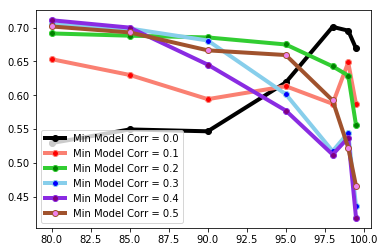

In [245]:
plt.plot([80,85,90,95,98,99,99.5],min_corr_00, marker='.', markerfacecolor='black', markersize=12, color='black', linewidth=4,label="Min Model Corr = 0.0")
plt.plot([80,85,90,95,98,99,99.5],min_corr_01, marker='.', markerfacecolor='red', markersize=12, color='salmon', linewidth=4,label="Min Model Corr = 0.1")
plt.plot([80,85,90,95,98,99,99.5],min_corr_02, marker='.', markerfacecolor='green', markersize=12, color='limegreen', linewidth=4,label="Min Model Corr = 0.2")
plt.plot([80,85,90,95,98,99,99.5],min_corr_03, marker='.', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label="Min Model Corr = 0.3")
plt.plot([80,85,90,95,98,99,99.5],min_corr_04, marker='.', markerfacecolor='purple', markersize=12, color='blueviolet', linewidth=4,label="Min Model Corr = 0.4")
plt.plot([80,85,90,95,98,99,99.5],min_corr_05, marker='.', markerfacecolor='violet', markersize=12, color='sienna', linewidth=4,label="Min Model Corr = 0.5")

plt.legend()

In [246]:
print("Percentile Module genes:\t" + "{:}".format(len(gene_modules_dict[0.0][98])))
print("PCC Module genes:\t" + "{:}".format(len(gene_modules_dict[0.5][80])))
print("Overlapping Genes:\t" + "{:}".format(len(set(gene_modules_dict[0.5][80]).intersection(gene_modules_dict[0.0][98]))))

Percentile Module genes:	93
PCC Module genes:	70
Overlapping Genes:	20


In [247]:
print("PCC M-Genes:\t" + "{:}".format(len(set(gene_modules_dict[0.5][80]).intersection(A549_Mgenes))))
print(set(gene_modules_dict[0.5][80]).intersection(A549_Mgenes))

PCC M-Genes:	16
{'CEP170', 'CALD1', 'TAGLN', 'BICC1', 'PLEKHO1', 'TGFB1I1', 'DSE', 'PDGFC', 'TNS1', 'SPOCK1', 'FSTL1', 'AKAP12', 'SRPX', 'NUAK1', 'FLRT2', 'COL5A2'}


In [248]:
print("PCC M-Genes:\t" + "{:}".format(len(set(gene_modules_dict[0.0][98]).intersection(A549_Mgenes))))
print(set(gene_modules_dict[0.0][98]).intersection(A549_Mgenes))

PCC M-Genes:	6
{'TAGLN', 'LGALS1', 'MSN', 'VIM', 'SPOCK1', 'GLIPR1'}
